<a href="https://colab.research.google.com/github/thiennguyen37-qn/bad-debt-prediction/blob/main/create_model_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BÀI TOÁN PHÂN LOẠI NHÓM NỢ CHO KHÁCH HÀNG ĐI VAY

- Import các thư viện cần thiết

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

- Khai báo các hàm để thực hiện các bước xử lí dữ liệu:
  + Hàm merge() dùng để ghép hai file dữ liệu vào với nhau, trong hàm merge() có hàm con renameCol() dùng để đồng nhất tên các cột của hai file dữ liệu lại với nhau

  + Hàm describe() để hiển thị các đại lượng thống kê mô tả cho các cột như số lượng giá trị khác NaN,trung bình, các tứ phân vị và độ lệch chuẩn

  + Hàm info() để hiển thị các kiểu dữ liệu của các cột cũng như số lượng giá trị khác NaN trong từng cột

  + Hàm replace_space() để thay thế các giá trị là dấu cách trong dataset thành NaN

  + Hàm dropna_target() để loại bỏ các hàng có cột mục tiêu là NaN

  + Hàm encode_target() để đồng bộ hóa các nhóm nợ lại với nhau (ví dụ '1' và 'Nhóm nợ 1' là hai giá trị mang ý nghĩa tương đương nhau có thể quy về '1')

  + Hàm drop_dup() để loại bỏ các bản ghi trùng nhau

  + Hàm drop_nullcol() để loại bỏ các cột có giá trị NaN chiếm hơn 1/2 bảng dữ liệu

  + Hàm drop_constant() để loại bỏ các cột chỉ nhận một giá trị duy nhất

  + Hàm countnull() để đếm số giá trị NaN trong từng cột của dữ liệu

  + Hàm countvalue() để đếm tần số xuất hiện của các giá trị trong từng cột của dữ liệu

  + Hàm toObject() để biến đổi một cột từ kiểu dữ liệu ban đầu thành kiểu Object

  + Hàm applyObject() để áp dụng hàm toObject() lên các cột cần thiết

  + Hàm convert_datetime() để chuyển đổi các cột kiểu datetime về một định dạng chung (yyyy-mm-dd hh-mm-ss)

  + Hàm create_numeric() để tạo ra một data frame mới chỉ gồm các cột kiểu số từ data frame ban đầu

  + Hàm corr_based() để vẽ ma trận tương quan của dữ liệu, liệt kê các cột có mối tương quan mạnh và trực quan hóa các mối tương quan này

  + Hàm box() để vẽ biểu đồ hộp của các cột

  + Hàm hist() để vẽ histogram của các cột

  + Hàm create_object() để tạo ra một data frame mới chỉ gồm các cột kiểu object từ data frame ban đầu

  + Hàm create_datetime() để tạo ra một data frame mới chỉ gồm các cột kiểu datetime từ data frame ban đầu

In [3]:
def merge():
  df1 = pd.read_excel('/content/drive/MyDrive/My Own Projects/Finance (2024)/Datasets/dulieu.xlsx')
  df2 = pd.read_excel('/content/drive/MyDrive/My Own Projects/Finance (2024)/Datasets/TAICHINH.xls')

  def renameCol(df):
    cols = list(df.columns)
    cols[cols.index('LoanType')] = 'LoaiHinhVay'
    cols[cols.index('InterestRateType')] = 'LoaiLaiSuat'
    cols[cols.index('LoanCapital')] = 'NguonVon'
    cols[cols.index('Group')] = 'NhomNo'
    cols[cols.index('InterestPaymentPeriod')] = 'PhanKyTraLai'
    cols[cols.index('InterestPaymentMethod')] = 'PhgThTraLai'
    cols[cols.index('EconomicComponent')] = 'ThanhPhanKinhTe'
    cols[cols.index('GuaranteedRate')] = 'TyLeBaoBam'
    cols[cols.index('CustomerType')] = 'custtpcdnm'
    return cols

  df1.columns = renameCol(df1)
  col_to_drop = list(set(df1.columns) - set(df2.columns))
  df1.drop(columns = col_to_drop,  inplace = True)
  df3 = df1.copy()
  df3.insert(0,'Makhachhang',pd.DataFrame([np.nan] * len(df3)))
  df3.insert(68,'loanprogram',pd.DataFrame([np.nan] * len(df3)))
  df3 = pd.concat([df2,df3], axis = 0)
  return df3

def describe(data):
  return data.describe().T

def info(data):
  return data.info()

def replace_space(data):
  df = data.copy()
  df.replace(r'^\s*$', np.nan, regex = True, inplace = True)
  df.dropna(subset = ['NhomNo'], inplace = True)
  return df

def dropna_target(data):
  df = data.copy()
  df.dropna(subset = ['NhomNo'], inplace = True)
  return df

def encode_target(data):
  df = data.copy()
  df['NhomNo'] = list(map(lambda x: str(x[5]) if (len(str(x)) > 1) \
                                              else str(x),df['NhomNo']))
  return df

def drop_dup(data):
  df = data.copy()
  df.drop_duplicates(inplace = True)
  return df

def drop_nullcol(data):
  df = data.copy()
  col_drop = ['Makhachhang']
  isnull = pd.DataFrame(df.isnull().sum(), columns = ['count_null'])
  print(isnull[isnull['count_null'] > 0.5 * len(df)])
  print('\n\n')
  for i in isnull[isnull['count_null'] > 0.5 * len(df)].index:
    col_drop.append(i)
  df = df.drop(columns = col_drop, axis = 1)
  return df

def drop_constant(data):
  df = data.copy()
  col_drop = []
  print('constant columns:')
  for i in df.columns:
    if (df[i].nunique() == 1):
      print(i)
      col_drop.append(i)
  df = df.drop(columns = col_drop, axis = 1)
  return df

def countnull(data):
  return pd.DataFrame(data.isnull().sum(), columns = ['count'])

def countvalue(data):
  for i in data.columns:
    print(data[i].value_counts())

def toObject(col):
  return df[col].astype(str)

def applyObject(data):
  df = data.copy()
  df['LoaiKhachHang'] = toObject('LoaiKhachHang')
  df['MaChiTietLoaiKhachHang'] = toObject('MaChiTietLoaiKhachHang')
  df['MaThanhPhanKinhTe'] = toObject('MaThanhPhanKinhTe')
  df['MaLoaiThue'] = toObject('MaLoaiThue')
  df['MaNganhKinhTe'] = toObject('MaNganhKinhTe')
  return df

def convert_datetime(data):
  df = data.copy()
  df['NgayPheDuyet'] = pd.to_datetime(df['NgayPheDuyet'])
  df['NgayGiaiNgan'] = list(map(lambda x: x if (len(str(x)) == 19) \
                                            else pd.to_datetime(x, origin = '1900-01-01', unit = 'D'),df['NgayGiaiNgan']))
  df['NgayDenHan'] = list(map(lambda x: x if (len(str(x)) == 19) \
                                            else pd.to_datetime(x, origin = '1900-01-01', unit = 'D'),df['NgayDenHan']))
  for i in ['NgayPheDuyet','NgayGiaiNgan','NgayDenHan']:
    df[i] = df[i].astype('datetime64[ns]')
  return df

def create_numeric(data):
  df = data.copy()
  numeric_df = df.select_dtypes(include = ['number'])
  return numeric_df

def corr_based(data):
  corr = pd.DataFrame(data.corr())
  plt.figure(figsize = (15,15))
  sb.heatmap(corr, annot = False, cmap = 'coolwarm')
  plt.show()
  x_scatter = []
  y_scatter = []
  for i in corr.index:
    for j in corr.columns:
      if (i > j) and (abs(corr.loc[i,j]) >= 0.7):
        print(i + ' ' + j + ' ' + str(corr.loc[i,j]))
        x_scatter.append(i)
        y_scatter.append(j)
  for i in range(len(x_scatter)):
    plt.scatter(data[x_scatter[i]],data[y_scatter[i]])
    plt.xlabel(x_scatter[i])
    plt.ylabel(y_scatter[i])
    plt.show()

def box(data):
  for i in data.columns:
    plt.title(i)
    try:
      sb.boxplot(data[i])
    except:
      continue
    plt.show()

def hist(data):
  for i in data.columns:
    plt.title(i)
    plt.yscale('log')
    sb.histplot(data[i], bins = 30)
    plt.show()

def clip_outliers_iqr(data):
  for column in df.columns:
      Q1 = data[column].quantile(0.25)
      Q3 = data[column].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      data[column] = data[column].clip(lower = lower_bound, upper = upper_bound)
  return data

def create_object(data):
  df = data.copy()
  object_df = df.select_dtypes(include = ['object'])
  return object_df

def create_datetime(data):
  df = data.copy()
  datetime_df = df.select_dtypes(include = ['datetime64[ns]'])
  return datetime_df

- Tiến hành ghép hai bảng dữ liệu từ file TAICHINH.xls và file dulieu.xlsx

In [4]:
df = merge()

In [5]:
df

,Makhachhang,NgayPheDuyet,NgayDenHanHopDong,TienTe,SoTienPheDuyet,SoGiaiNgan,NgayGiaiNgan,NgayDenHan,LaiSuat,LaiSuatQuaHan,...,LoaiLaiSuat,MaLSThaNoi,SoTkKoKyHan,TongTkKoKyHan,StoTkCoKyHan,TongTkCoKyhan,SoTkATM,TongTkATM,loanprogram,GhiChu
0,PC601509,2010-07-16 00:00:00,2011-07-14,VND,4.000000e+08,LDS201004112601380,2010-07-16 00:00:00,2011-07-14 00:00:00,13.0,6.50,...,Cố định [Fixed rate],,0.0,0.0,0.0,0.0,0.0,0.0,Cho vay NoNT,NaN
1,PC751527,2011-01-21 00:00:00,2011-07-21,VND,3.000000e+09,LDS201100608751398,2011-01-21 00:00:00,2011-07-21 00:00:00,13.0,6.50,...,Cố định [Fixed rate],,0.0,0.0,0.0,0.0,0.0,0.0,Cho vay NoNT,NaN
2,PC764811,2014-05-14 00:00:00,2019-05-14,VND,5.000000e+07,LDS201421081764682,2014-05-14 00:00:00,2019-05-14 00:00:00,11.7,5.85,...,Cố định [Fixed rate],,0.0,0.0,0.0,0.0,1.0,-7859953.0,Cho vay theo NĐ 41,NaN
3,PC853629,2014-07-16 00:00:00,2019-07-15,VND,1.500000e+08,LDS201422089853500,2014-07-16 00:00:00,2019-07-15 00:00:00,11.7,5.85,...,Cố định [Fixed rate],,0.0,0.0,0.0,0.0,1.0,633.0,Cho vay NoNT,NaN
4,PC750420,2014-07-18 00:00:00,2019-07-18,VND,5.000000e+07,LDS201422129750291,2014-07-18 00:00:00,2019-07-18 00:00:00,11.5,5.75,...,Cố định [Fixed rate],,0.0,0.0,0.0,0.0,1.0,61697.0,Cho vay theo NĐ 41,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,NaN,15/06/2022,NaT,VND,1.000000e+08,NaN,44727,46553,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8019,NaN,09/10/2019,NaT,VND,7.000000e+07,NaN,43718,45545,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8020,NaN,30/09/2021,NaT,VND,8.000000e+07,NaN,44469,45565,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8021,NaN,31/12/2021,NaT,VND,4.000000e+08,NaN,44561,46022,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Bộ dữ liệu sau khi được ghép có tất cả 12868 dòng và 70 cột

- Thực hiện các thao tác thay thế khoảng trắng, loại bỏ các hàng có giá trị NaN ở cột mục tiêu, đồng bộ hóa cột mục tiêu, loại bỏ các bản ghi trùng lặp, loại bỏ các cột mà giá trị NaN chiếm hơn một nửa và các cột hằng số

In [6]:
df = replace_space(df)
df = dropna_target(df)
df = encode_target(df)
df = drop_dup(df)
df = drop_nullcol(df)
df = drop_constant(df)

                    count_null
Makhachhang               8018
NgayTraGocCuoiCung        8774
GoiHoTroLaiSuat          12803
MaToVayVon               12033
PhgThucGN2               12844
TaiKhoanGN2              12849
MaLSThaNoi               12849
loanprogram               8516
GhiChu                    7284



constant columns:
TienTe
LoaiTienGiaiNgan
subunit
TrangThaiKhachHang
exmtintamt
exmtintamt2
KieuTraLai


In [7]:
df

,NgayPheDuyet,NgayDenHanHopDong,SoTienPheDuyet,SoGiaiNgan,NgayGiaiNgan,NgayDenHan,LaiSuat,LaiSuatQuaHan,SoTienGiaiNgan,SoGocDaThu,...,PhgThTraLai,PhanKyTraLai,AnHanLai,LoaiLaiSuat,SoTkKoKyHan,TongTkKoKyHan,StoTkCoKyHan,TongTkCoKyhan,SoTkATM,TongTkATM
0,2010-07-16 00:00:00,2011-07-14,4.000000e+08,LDS201004112601380,2010-07-16 00:00:00,2011-07-14 00:00:00,13.0,6.50,4.000000e+08,3.999990e+08,...,Một lần,0,0.0,Cố định [Fixed rate],0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-21 00:00:00,2011-07-21,3.000000e+09,LDS201100608751398,2011-01-21 00:00:00,2011-07-21 00:00:00,13.0,6.50,3.000000e+09,2.999900e+09,...,Từng phần,3,0.0,Cố định [Fixed rate],0.0,0.0,0.0,0.0,0.0,0.0
2,2014-05-14 00:00:00,2019-05-14,5.000000e+07,LDS201421081764682,2014-05-14 00:00:00,2019-05-14 00:00:00,11.7,5.85,5.000000e+07,4.500000e+07,...,Từng phần,3,0.0,Cố định [Fixed rate],0.0,0.0,0.0,0.0,1.0,-7859953.0
3,2014-07-16 00:00:00,2019-07-15,1.500000e+08,LDS201422089853500,2014-07-16 00:00:00,2019-07-15 00:00:00,11.7,5.85,1.500000e+08,1.250000e+08,...,Từng phần,6,0.0,Cố định [Fixed rate],0.0,0.0,0.0,0.0,1.0,633.0
4,2014-07-18 00:00:00,2019-07-18,5.000000e+07,LDS201422129750291,2014-07-18 00:00:00,2019-07-18 00:00:00,11.5,5.75,5.000000e+07,4.250000e+07,...,Từng phần,6,0.0,Cố định [Fixed rate],0.0,0.0,0.0,0.0,1.0,61697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,15/06/2022,NaT,1.000000e+08,NaN,44727,46553,9.2,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8019,09/10/2019,NaT,7.000000e+07,NaN,43718,45545,11.0,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8020,30/09/2021,NaT,8.000000e+07,NaN,44469,45565,11.0,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8021,31/12/2021,NaT,4.000000e+08,NaN,44561,46022,11.0,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Sau khi thực hiện các bước trên, ta có bảng dữ liệu mới gồm 12849 dòng và 54 cột. Như vậy, bộ dữ liệu ban đầu có tổng cộng 19 bản ghi trùng lặp và bản ghi có giá trị NaN ở cột mục tiêu, cùng với đó là 7 cột hằng số và 9 cột có giá trị NaN chiếm hơn một nửa

- Thực hiện thống kê mô tả bằng phương thức describe() và chuyển vị bảng thống kê để có thể bao quát được toàn bộ các cột

In [8]:
describe(df)

,count,mean,min,25%,50%,75%,max,std
NgayDenHanHopDong,11600,2019-08-07 13:47:00.413793024,2011-04-20 00:00:00,2019-05-08 00:00:00,2019-09-14 00:00:00,2020-04-10 00:00:00,2033-03-06 00:00:00,NaN
SoTienPheDuyet,12849.0,267524581.587283,2000000.0,40000000.0,70000000.0,150000000.0,49309157890.000008,1367678121.649741
LaiSuat,12849.0,8.832707,0.0,8.2,9.0,9.9,21.0,3.526824
LaiSuatQuaHan,11600.0,4.329411,0.0,4.1,4.5,4.65,10.5,1.819434
SoTienGiaiNgan,11600.0,116807531.633017,11216.0,40000000.0,60000000.0,110000000.0,6443351921.0,259434778.264911
SoGocDaThu,11600.0,7973771.894224,0.0,0.0,0.0,1000000.0,2999900000.0,49776285.64631
SoLaiDaThu,11600.0,5979141.404397,0.0,0.0,2963534.5,6623105.0,931529917.0,24696280.717618
DuNo,11600.0,108833759.738793,1000.0,30000000.0,50000000.0,100000000.0,6443351921.0,251834568.457103
SoTienGiaiNganTrongKy,11600.0,4542327.586207,0.0,0.0,0.0,0.0,2750000000.0,61276823.870407
SoGocDaThuTrongKy,11600.0,74498.232759,0.0,0.0,0.0,0.0,124471000.0,2025119.444785


- Một vài điểm đáng chú ý trong bảng thống kê mô tả (chỉ gồm các cột nhận giá trị kiểu số (numeric) và kiểu datetime):
  + Tổng số bản ghi của bộ dữ liệu là 12849 nhưng chỉ có một số ít cột là có đầy đủ thông tin (không có giá trị NaN), trong khi đó rất nhiều cột xuất hiện NaN và đều có số bản ghi đầy đủ bằng 11600, khả năng rất cao các cột này chứa các giá trị NaN đồng thời với nhau. Ta sẽ kiểm tra điều này ở phần sau
  
  + Các đại lượng mean, std, min, max, tứ phân vị của cột LaiSuat gần như gấp đôi hoặc xấp xỉ gấp đôi so với cột LaiSuatQuaHan; chúng ta có thể dự đoán hai cột này có mối tương quan tuyến tính rất mạnh

  + Cột LoaiKhachHang và MaChiTietLoaiKhachHang có các đại lượng thống kê gần như tương đương nhau, ta cũng có thể dự đoán hai cột này khả năng cao đã bị định dạng nhầm từ kiểu chuỗi sang kiểu số

  + Các cột MaNganhKinhTe, MaThanhPhanKinhTe, MaLoaiThue có thể cũng đã gặp vấn đề định dạng tương tự như cột MaChiTietLoaiKhachHang

  + Cột NgayTraGocSapToi và NgayTraLaiSapToi có giá trị min là ngày 2 tháng 1 năm 1900 (1900-01-02). Đây có thể là một sai sót từ phía người đánh máy

  + Cột TongTkATM có trung bình là giá trị âm

- Áp dụng hàm applyObject lên các cột thích hợp, ở đây là các cột mã định danh dùng để phân biệt các loại thuế, ngành kinh tế,... khác nhau

In [9]:
df = applyObject(df)

- Tiếp theo, ta áp dụng hàm info lên bộ dữ liệu

In [10]:
info(df)

<class 'pandas.core.frame.DataFrame'>
Index: 12849 entries, 0 to 8022
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   NgayPheDuyet            12849 non-null  object        
 1   NgayDenHanHopDong       11600 non-null  datetime64[ns]
 2   SoTienPheDuyet          12849 non-null  float64       
 3   SoGiaiNgan              11600 non-null  object        
 4   NgayGiaiNgan            12849 non-null  object        
 5   NgayDenHan              12849 non-null  object        
 6   LaiSuat                 12849 non-null  float64       
 7   LaiSuatQuaHan           11600 non-null  float64       
 8   SoTienGiaiNgan          11600 non-null  float64       
 9   SoGocDaThu              11600 non-null  float64       
 10  SoLaiDaThu              11600 non-null  float64       
 11  DuNo                    11600 non-null  float64       
 12  SoTienGiaiNganTrongKy   11600 non-null  float64     

- Có tất cả 23 cột kiểu object, 27 cột kiểu số và 4 cột kiểu datetime
- Ta có thể dễ dàng thấy các cột NgayPheDuyet, NgayGiaiNgan, NgayDenHan đã bị định dạng nhầm sang kiểu object, dường như các cột này có các cách định dạng ngày tháng năm khác nhau khiến cho dữ liệu không thể chuyển đổi thành kiểu datetime

- Áp dụng hàm convert_datetime để chuyển các cột thích hợp về cùng một định dạng ngày tháng năm và chuyển chúng về kiểu datetime

In [11]:
df = convert_datetime(df)

- Tiếp theo tạo data frame "null" để đếm số giá trị thiếu của từng cột, và in ra các cột tồn tại NaN

In [12]:
null = countnull(df)
null[null['count'] > 0]

,count
NgayDenHanHopDong,1249
SoGiaiNgan,1249
LaiSuatQuaHan,1249
SoTienGiaiNgan,1249
SoGocDaThu,1249
SoLaiDaThu,1249
DuNo,1249
SoTienGiaiNganTrongKy,1249
SoGocDaThuTrongKy,1249
SoLaiDaThuTrongKy,1249


- Rất nhiều cột có số giá trị NaN là 1249, tương đương với việc có 11600 bản ghi đầy đủ như chúng ta đã thấy ở bước mô tả dữ liệu bằng hàm describe()

- Tiếp theo, ta kiểm tra liệu các cột này có xuất hiện NaN đồng thời với nhau hay không

In [13]:
index1249 = list(null[null['count'] == 1249].index)
df[df['SoGiaiNgan'].isnull()][index1249].drop_duplicates().T

,6769
NgayDenHanHopDong,NaT
SoGiaiNgan,NaN
LaiSuatQuaHan,NaN
SoTienGiaiNgan,NaN
SoGocDaThu,NaN
SoLaiDaThu,NaN
DuNo,NaN
SoTienGiaiNganTrongKy,NaN
SoGocDaThuTrongKy,NaN
SoLaiDaThuTrongKy,NaN


- Kết quả trên cho ta thấy 100% giá trị NaN xuất hiện đồng thời ở các cột này. Sau đây ta sẽ đếm tần số xuất hiện của các nhóm nợ và kiểm tra xem các bản ghi có các giá trị NaN xuất hiện đồng thời ở các cột trên thuộc nhóm nợ nào

In [14]:
df['NhomNo'].value_counts()

,count
NhomNo,
1,11571
2,738
5,210
4,200
3,130


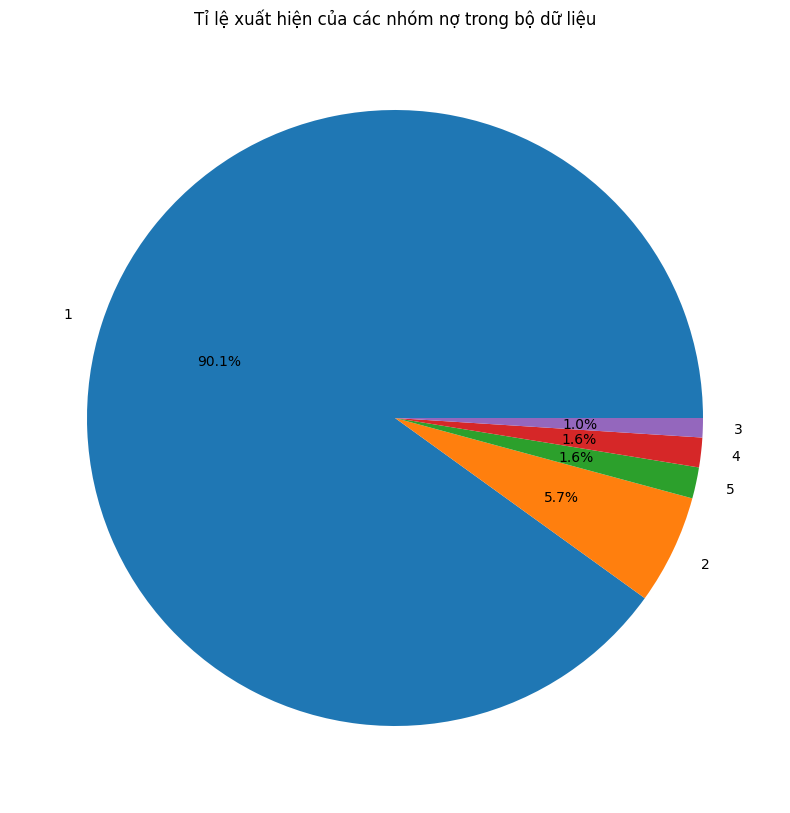

In [15]:
plt.figure(figsize = (10,10))
plt.title("Tỉ lệ xuất hiện của các nhóm nợ trong bộ dữ liệu")
plt.pie(df['NhomNo'].value_counts(), labels = df['NhomNo'].value_counts().index, autopct = '%1.1f%%')
plt.show()

In [16]:
df[df['SoGiaiNgan'].isnull()]['NhomNo'].drop_duplicates()

,NhomNo
6769,2
7492,3
7621,4
7720,5


- Có tổng cộng 5 nhóm nợ. Nhóm nợ 1 (nợ đủ tiêu chuẩn) có tần số xuất hiện vượt trội so với 4 nhóm nợ còn lại, cho thấy đây là một bộ dữ liệu bị mất cân bằng nghiêm trọng

- Các bản ghi có giá trị NaN xuất hiện đồng thời ở các cột được nêu trên chỉ rơi vào nhóm nợ 2, 3, 4, 5

- Ta sẽ kiểm tra tỉ lệ giữa tần số xuất hiện của các bản ghi này so với tần số xuất hiện của từng nhóm nợ

In [17]:
a = pd.merge(df['NhomNo'].value_counts().to_frame(), \
             df[df['SoGiaiNgan'].isnull()]['NhomNo'].value_counts().to_frame(), \
             left_index = True, right_index = True)
a.columns = ['count','count_null']
a['%count_null'] = round(100 * a['count_null'] / a['count'],2)
a.sort_index()

,count,count_null,%count_null
NhomNo,,,
2,738,719,97.43
3,130,129,99.23
4,200,198,99.00
5,210,203,96.67


- Dựa vào bảng kết quả trên:
  + 97.43% các khách hàng thuộc nhóm nợ 2 (nợ cần chú ý) bị khuyết thông tin ở các cột trên

  + Đối với nhóm nợ 3 (nợ dưới tiêu chuẩn), nhóm nợ 4 (nợ nghi ngờ), nhóm nợ 5 (nợ có khả năng mất vốn) các tỉ lệ lần lượt là 99.23%, 99% và 96.67%

- Như vậy, muốn xử lí các giá trị NaN này bằng cách điền thêm thông tin thì gần như phải dựa vào nguồn thông tin có được ở các khách hàng thuộc nhóm nợ 1. Ta có thể lựa chọn không đưa các cột trên vào việc huấn luyện mô hình nhưng vẫn có thể giữ lại chúng để phục vụ cho việc trực quan hóa

- Sau đây nhóm sẽ chia bộ dữ liệu ban đầu thành các bộ dữ liệu con có các cột cùng kiểu dữ liệu với nhau để áp dụng các hình thức xử lí khác nhau với từng kiểu dữ liệu

- Đầu tiên, tạo một data frame mới chỉ gồm các cột kiểu số từ data frame ban đầu

In [18]:
numeric_df = create_numeric(df)
numeric_df

,SoTienPheDuyet,LaiSuat,LaiSuatQuaHan,SoTienGiaiNgan,SoGocDaThu,SoLaiDaThu,DuNo,SoTienGiaiNganTrongKy,SoGocDaThuTrongKy,SoLaiDaThuTrongKy,...,SoTienGNPhgTh2,TyTrongNguonVon,PhanKyTraLai,AnHanLai,SoTkKoKyHan,TongTkKoKyHan,StoTkCoKyHan,TongTkCoKyhan,SoTkATM,TongTkATM
0,4.000000e+08,13.0,6.50,4.000000e+08,3.999990e+08,28443333.0,1000.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.000000e+09,13.0,6.50,3.000000e+09,2.999900e+09,131841667.0,100000.0,0.0,0.0,0.0,...,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.000000e+07,11.7,5.85,5.000000e+07,4.500000e+07,15378219.0,5000000.0,0.0,0.0,0.0,...,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,1.0,-7859953.0
3,1.500000e+08,11.7,5.85,1.500000e+08,1.250000e+08,44728659.0,25000000.0,0.0,0.0,0.0,...,0.0,0.0,6,0.0,0.0,0.0,0.0,0.0,1.0,633.0
4,5.000000e+07,11.5,5.75,5.000000e+07,4.250000e+07,14831084.0,7500000.0,0.0,0.0,0.0,...,0.0,0.0,6,0.0,0.0,0.0,0.0,0.0,1.0,61697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,1.000000e+08,9.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8019,7.000000e+07,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8020,8.000000e+07,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8021,4.000000e+08,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Đếm số giá trị NaN trong numeric_df

In [19]:
countnull(numeric_df)

,count
SoTienPheDuyet,0
LaiSuat,0
LaiSuatQuaHan,1249
SoTienGiaiNgan,1249
SoGocDaThu,1249
SoLaiDaThu,1249
DuNo,1249
SoTienGiaiNganTrongKy,1249
SoGocDaThuTrongKy,1249
SoLaiDaThuTrongKy,1249


- Tiếp theo, áp dụng hàm corr_based() lên numeric_df để tìm hiểu thêm về độ tương quan giữa các cột

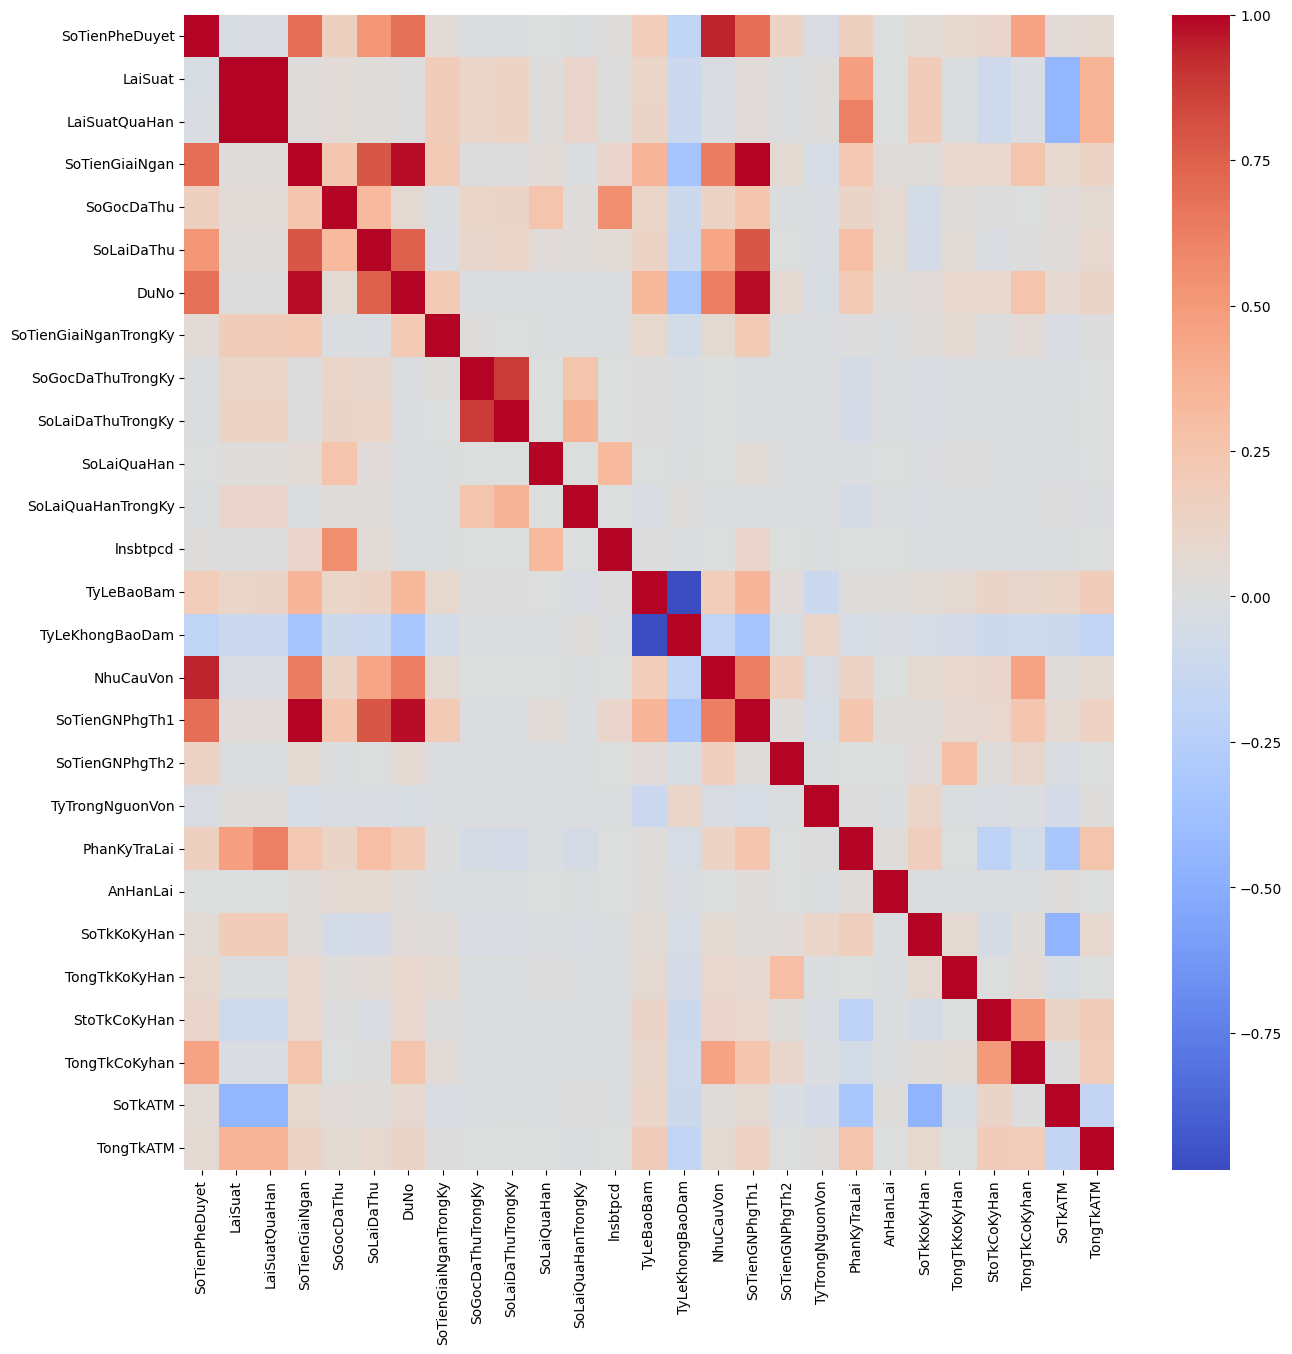

SoTienPheDuyet NhuCauVon 0.9403051376434054
LaiSuatQuaHan LaiSuat 0.9997364212313535
SoTienGiaiNgan SoLaiDaThu 0.7874967756881485
SoTienGiaiNgan DuNo 0.9814806110310873
SoTienGiaiNgan SoTienGNPhgTh1 0.99818091623825
SoLaiDaThu DuNo 0.7479212106393824
SoLaiDaThuTrongKy SoGocDaThuTrongKy 0.8767156528256083
TyLeKhongBaoDam TyLeBaoBam -0.9853042726329897
SoTienGNPhgTh1 SoLaiDaThu 0.7852617329025221
SoTienGNPhgTh1 DuNo 0.9800318053571064


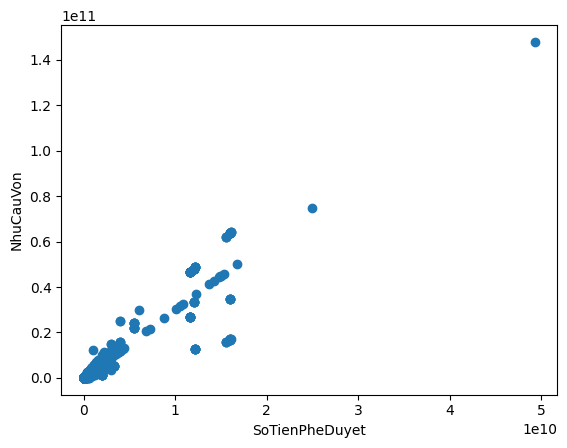

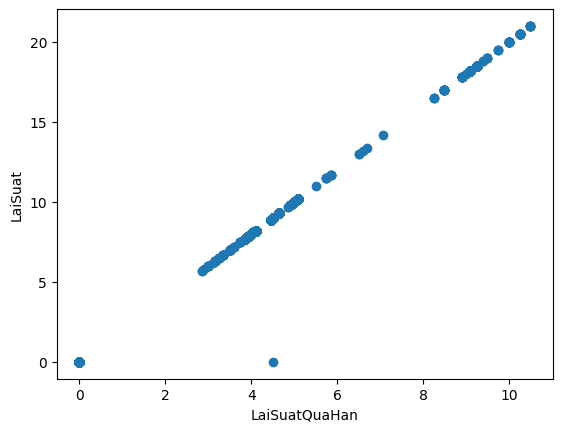

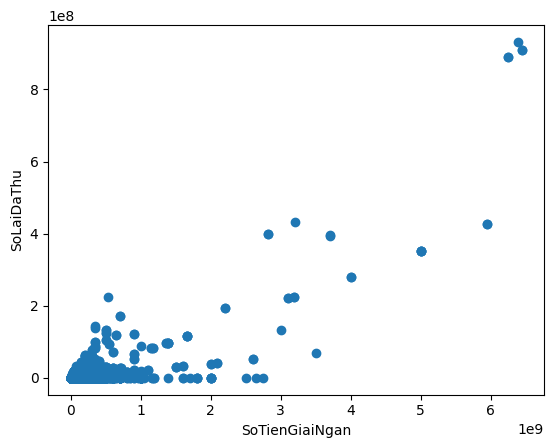

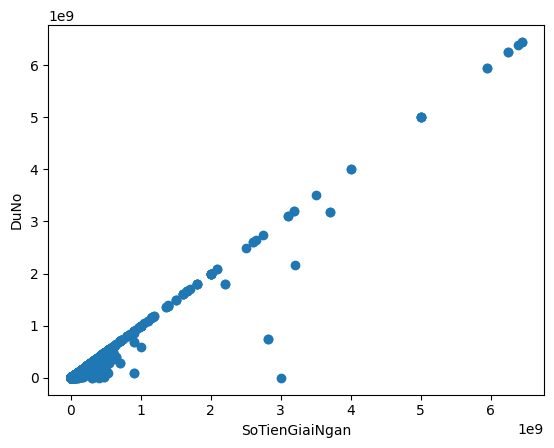

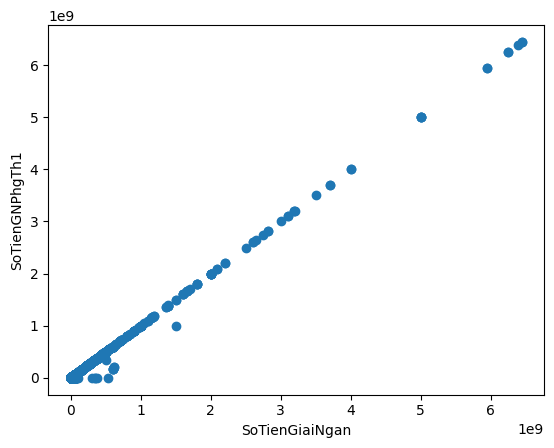

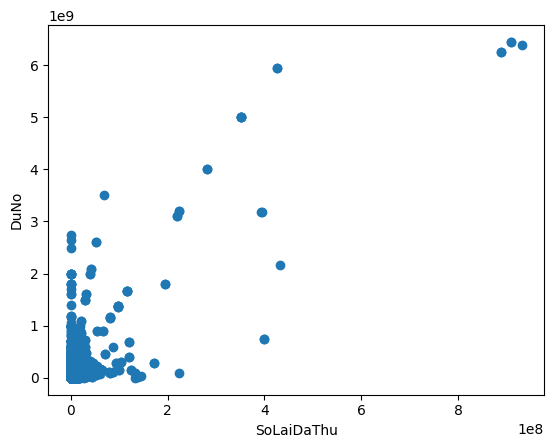

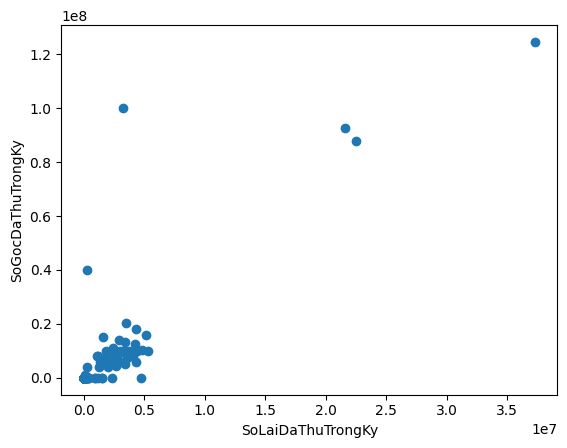

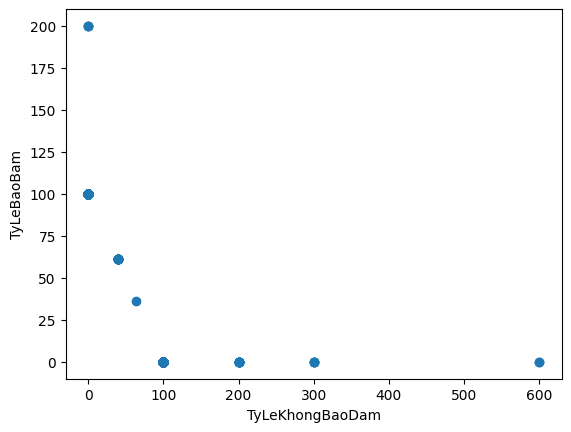

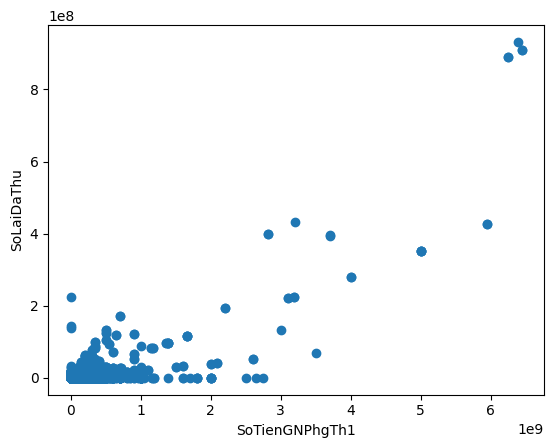

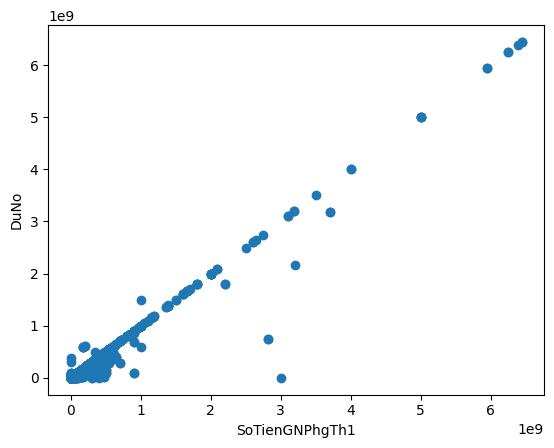

In [20]:
corr_based(numeric_df)

- Đối với các cặp đặc trưng có mức độ tương quan cao (ở đây ngưỡng tương quan cao được chọn là 0.7) ta có thể bỏ đi một trong hai cột

In [21]:
numeric_df.drop(['SoTienPheDuyet','LaiSuatQuaHan','SoLaiDaThu','DuNo','SoTienGNPhgTh1','SoLaiDaThuTrongKy','TyLeKhongBaoDam'], axis = 1, inplace = True)

- Kiểm tra giá trị ngoại lai (outlier) bằng biểu đồ hộp

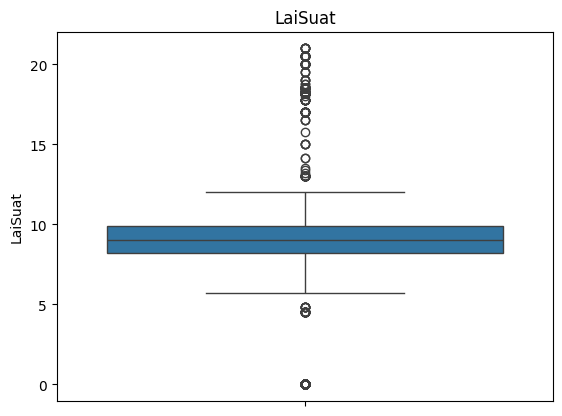

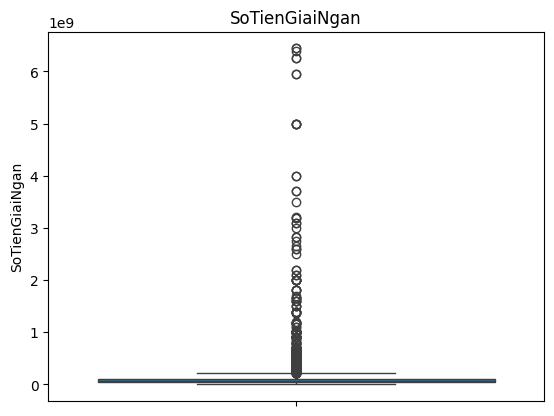

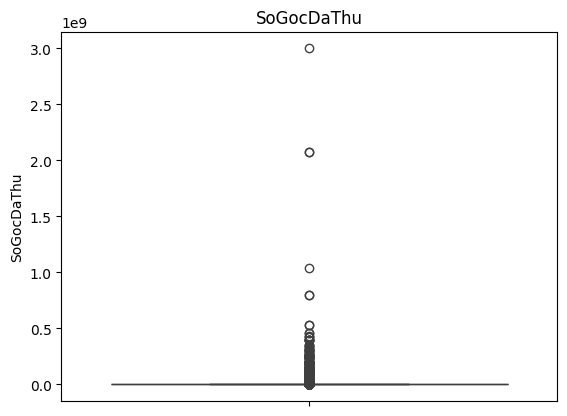

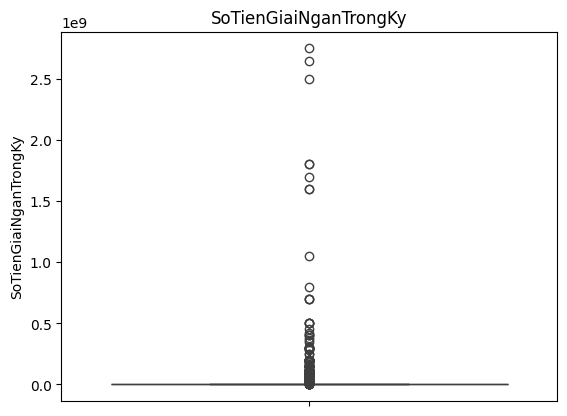

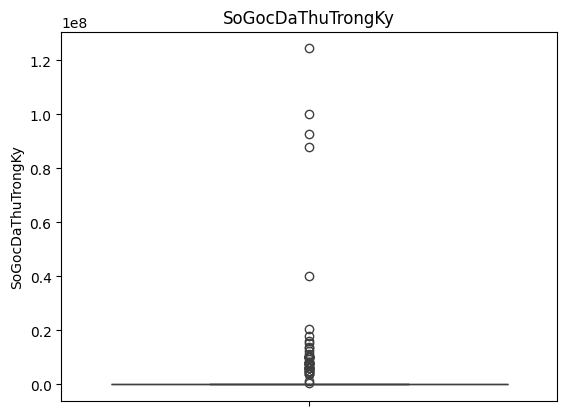

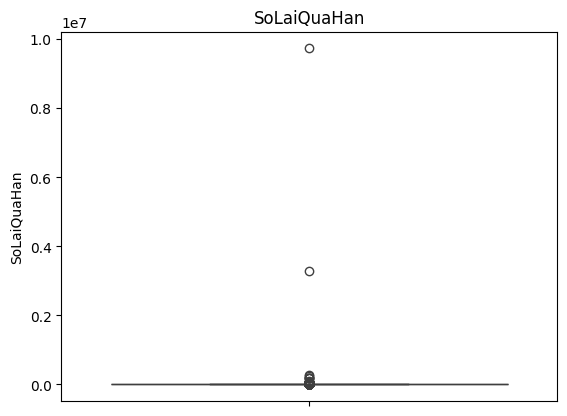

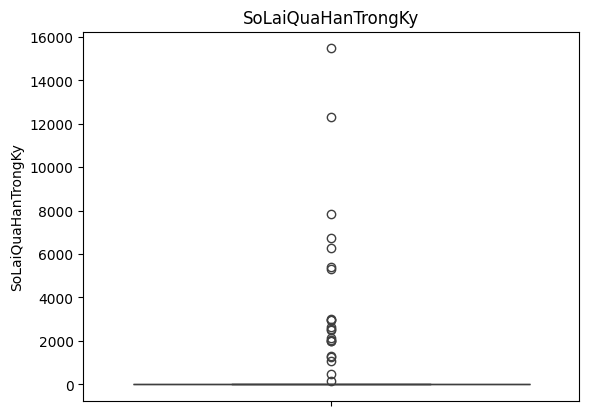

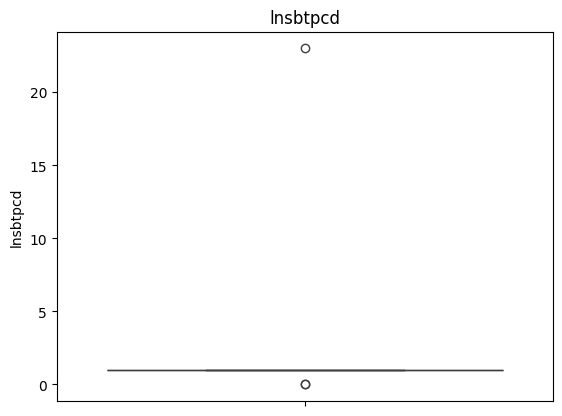

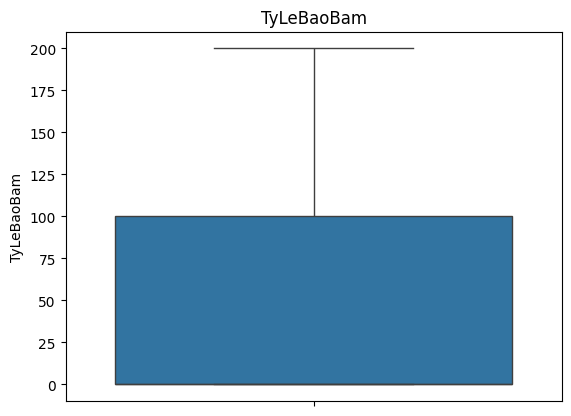

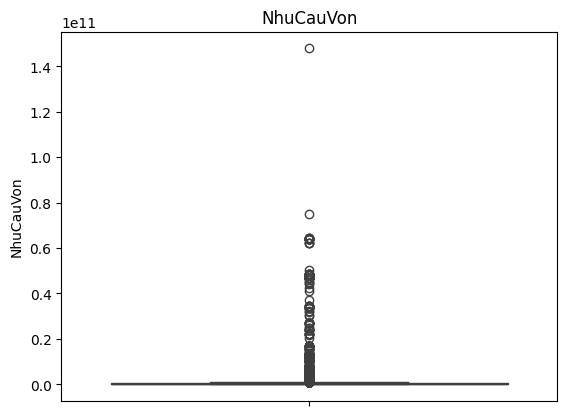

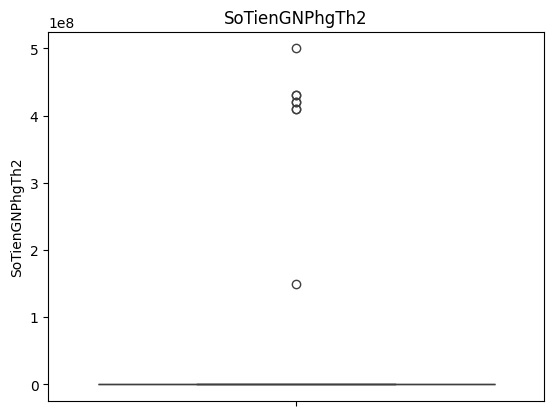

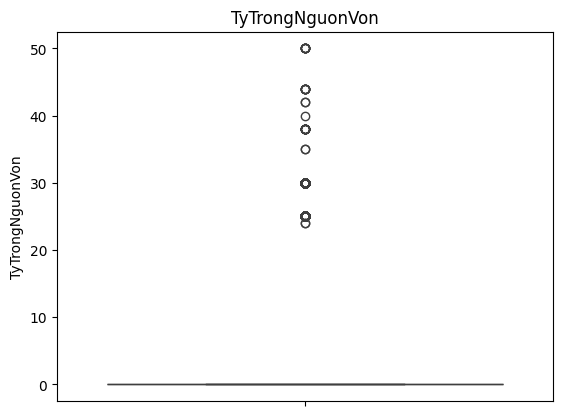

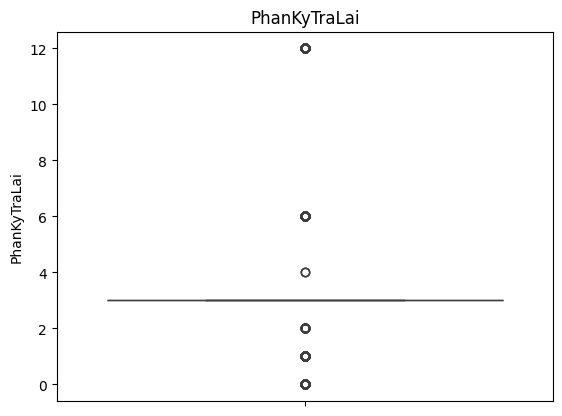

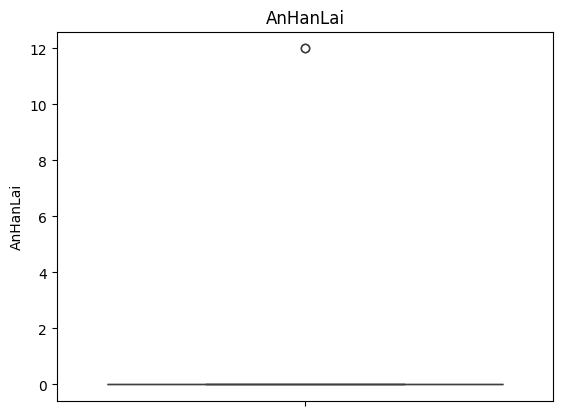

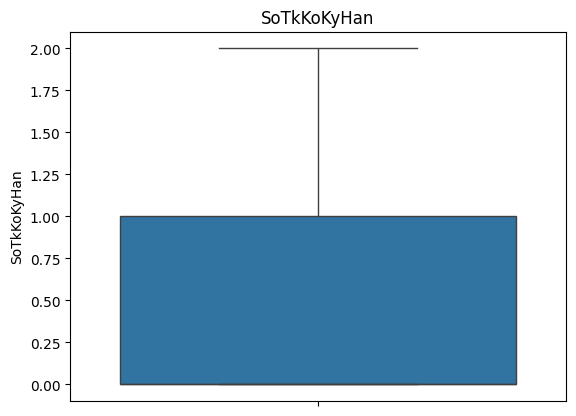

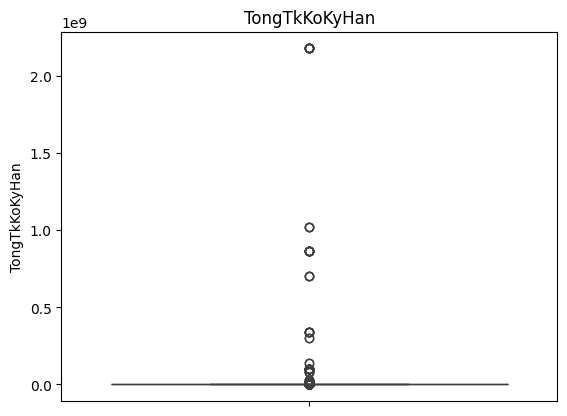

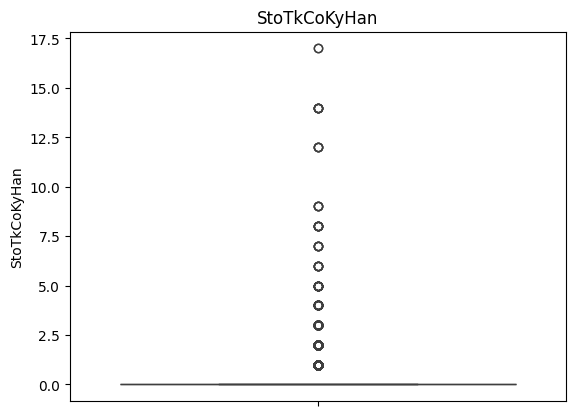

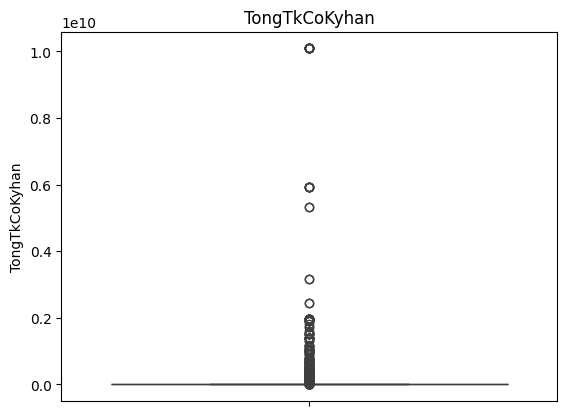

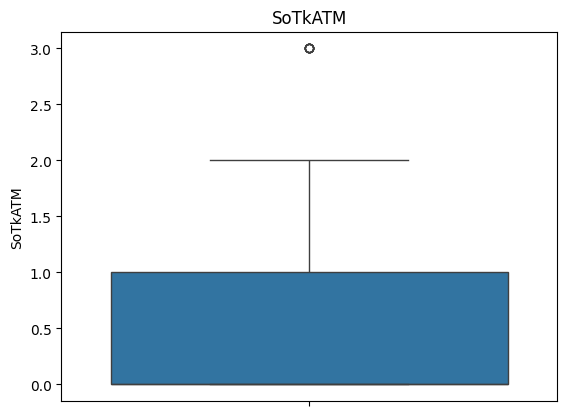

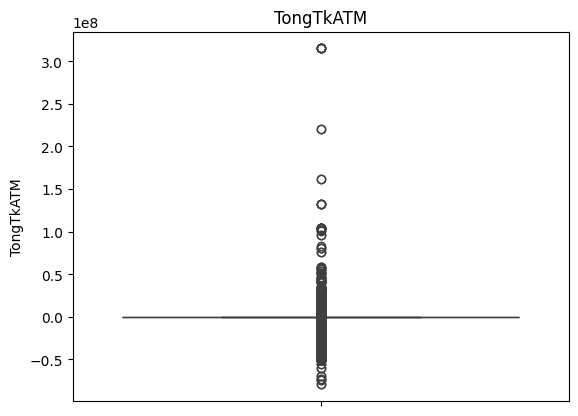

In [22]:
box(numeric_df)

- Kiểm tra phân phối của các cột bằng histogram

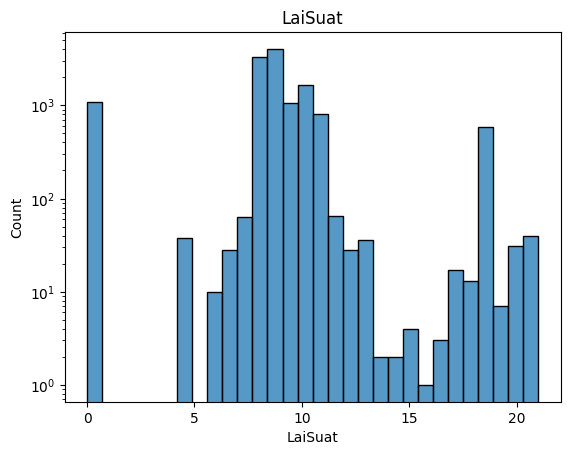

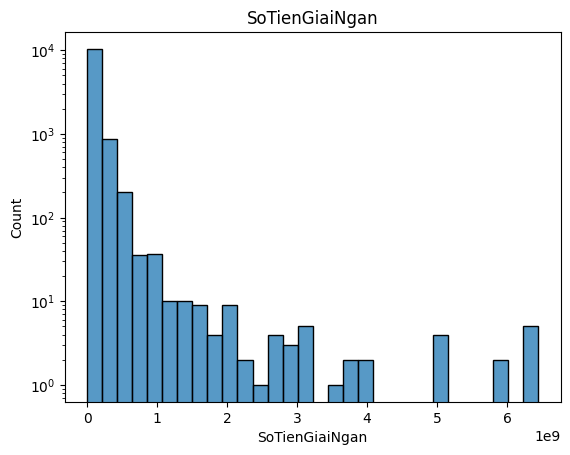

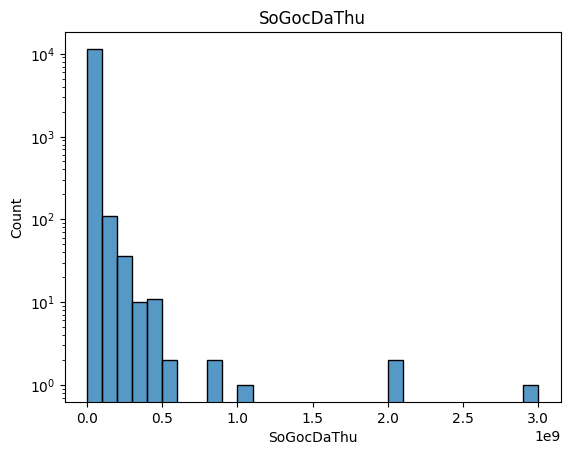

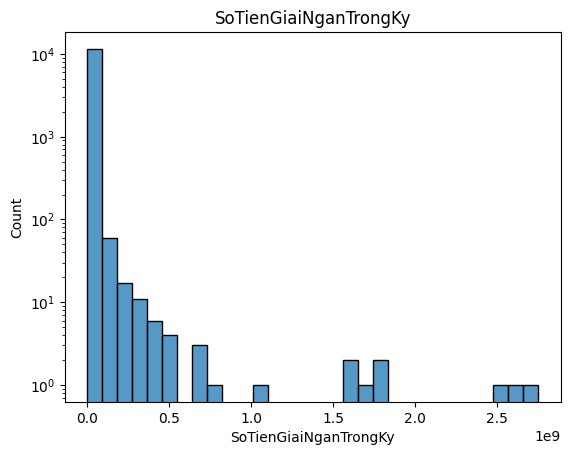

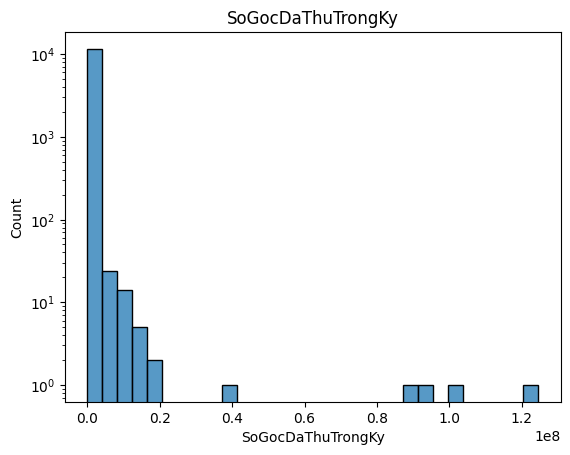

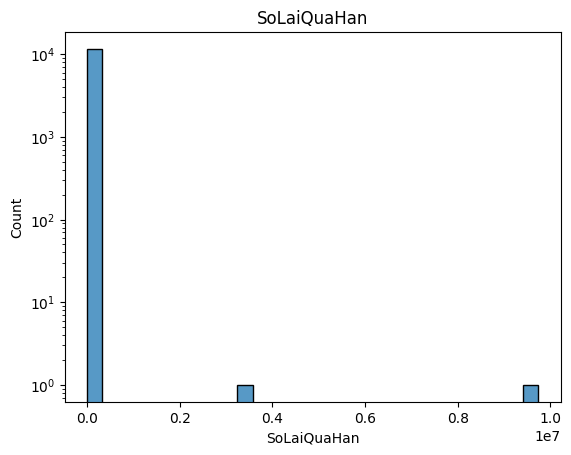

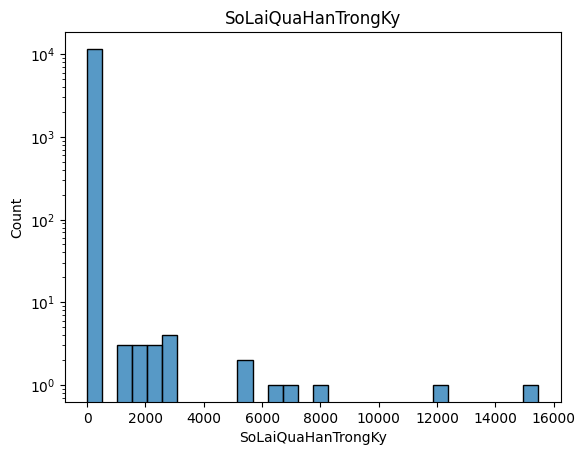

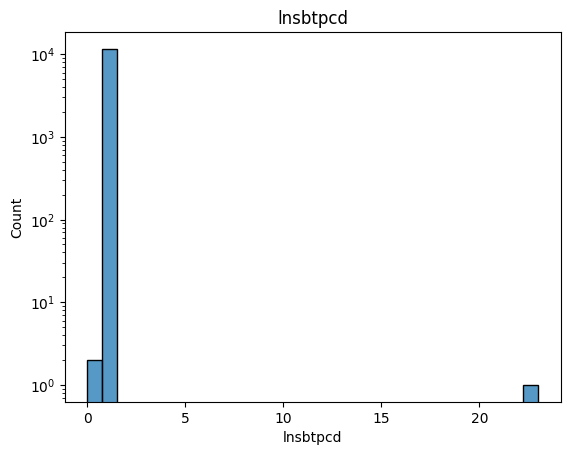

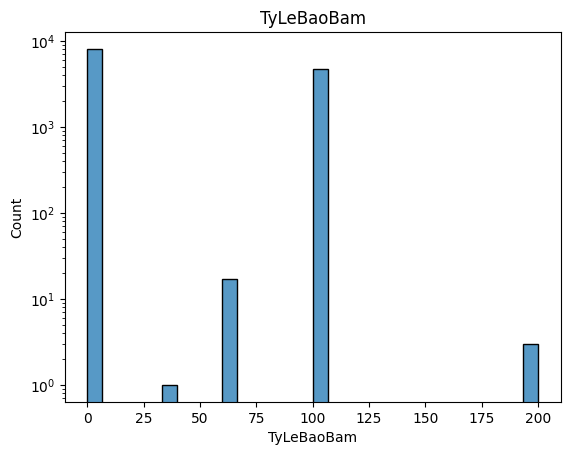

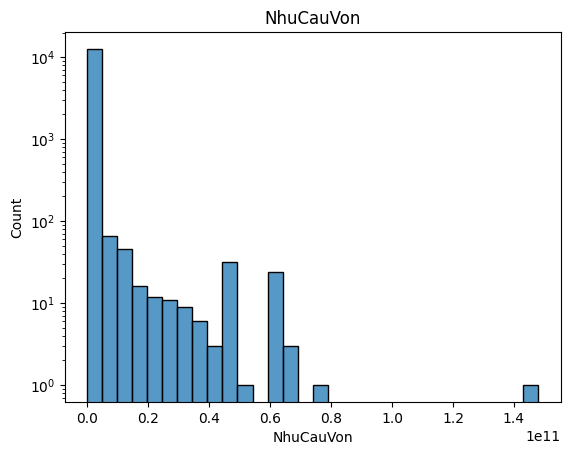

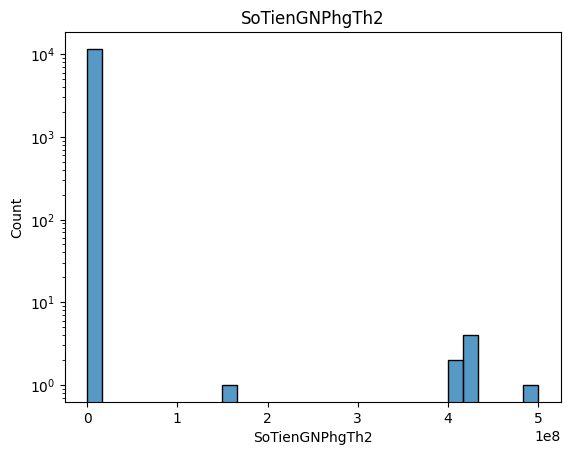

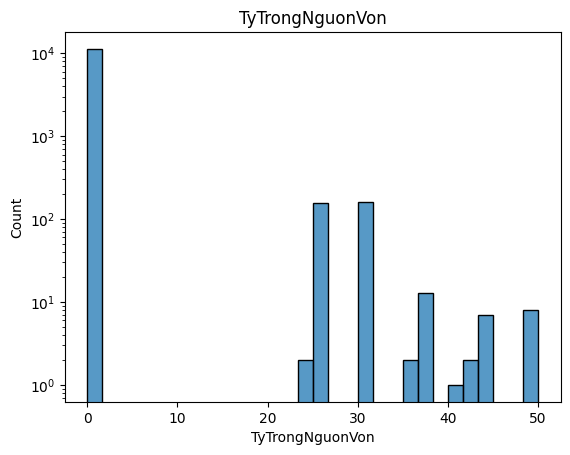

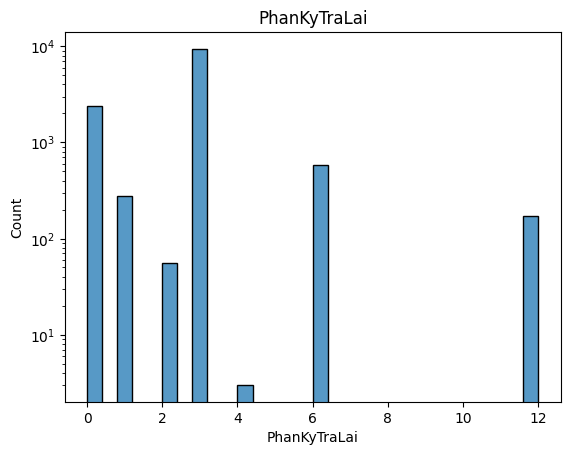

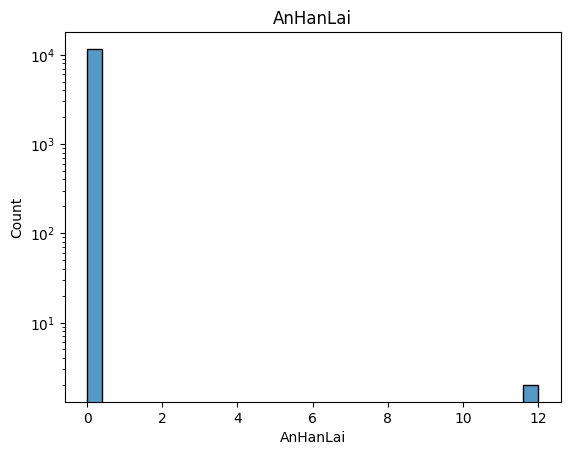

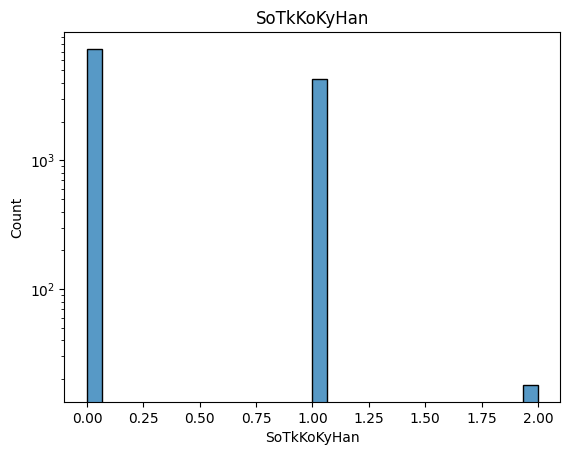

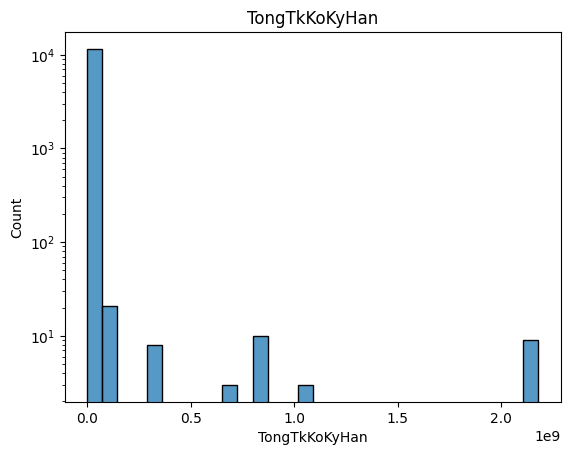

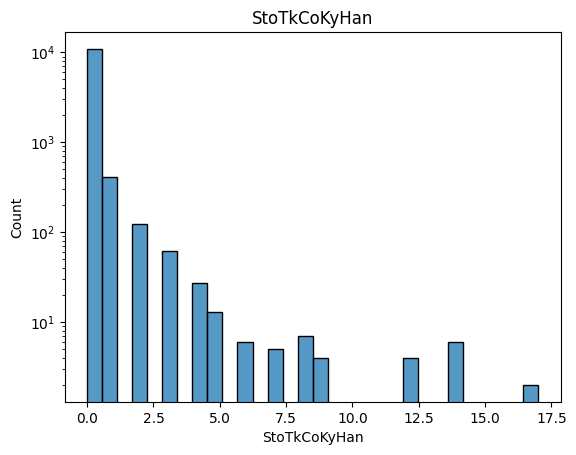

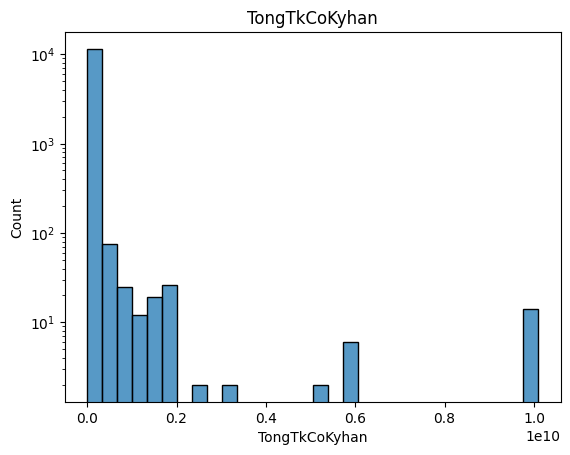

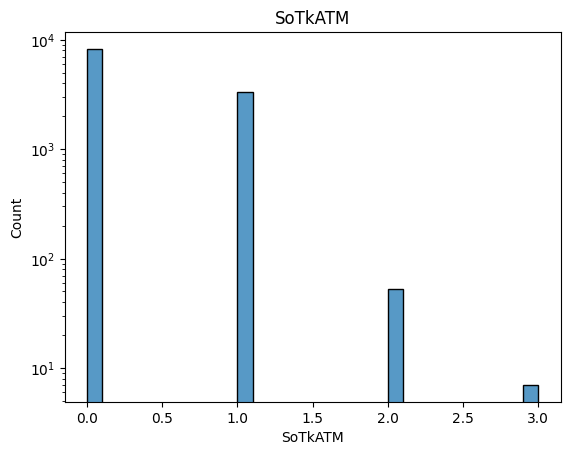

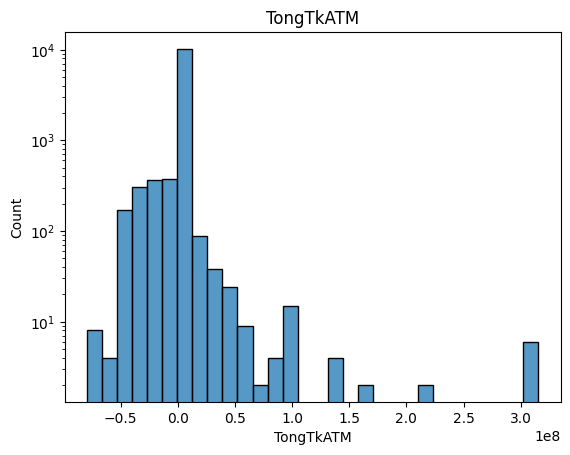

In [23]:
hist(numeric_df)

- Đưa các cột kiểu số không tồn tại giá trị NaN vào mô hình huấn luyện

In [24]:
model_cols = []
model_cols.extend(countnull(numeric_df)[countnull(numeric_df)['count'] == 0].index)

- Tiếp theo, tạo một data frame chỉ gồm các cột object từ data frame ban đầu

In [25]:
object_df = create_object(df)
object_df

,SoGiaiNgan,LoaiKhachHang,MaChiTietLoaiKhachHang,ChiTietLoaiKhachHang,MaThanhPhanKinhTe,ThanhPhanKinhTe,MaLoaiThue,LoaiThue,custtpcdnm,NghiepVu,LoaiHinhVay,NguonVon,TrangThaiHoTroLaiSuat,NganhKinhTe,MaNganhKinhTe,NhomNo,PhuongThucGN1,PhgThTraNo,PhgThTraLai,LoaiLaiSuat
0,LDS201004112601380,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay ngắn hạn (TK 211),Vốn Kinh doanh,Không hỗ trợ,Bán lẻ thiết bị công nghệ thông tin liên lạc t...,101103,5,Cash,Một lần,Một lần,Cố định [Fixed rate]
1,LDS201100608751398,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay ngắn hạn (TK 211),Vốn Kinh doanh,Không hỗ trợ,Bán lẻ thiết bị công nghệ thông tin liên lạc t...,101103,5,Cash,Một lần,Từng phần,Cố định [Fixed rate]
2,LDS201421081764682,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay trung hạn (TK 212),Vốn Kinh doanh,Không hỗ trợ,Mua sắm vật dụng sinh hoạt,240104,1,Cash,Từng phần,Từng phần,Cố định [Fixed rate]
3,LDS201422089853500,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay trung hạn (TK 212),Vốn Kinh doanh,Không hỗ trợ,"Sửa chữa, xây mới nhà",240101,1,Cash,Từng phần,Từng phần,Cố định [Fixed rate]
4,LDS201422129750291,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay trung hạn (TK 212),Vốn Kinh doanh,Không hỗ trợ,"Sửa chữa, xây mới nhà",240101,1,Cash,Từng phần,Từng phần,Cố định [Fixed rate]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,NaN,10307,4,NaN,NaN,NaN,NaN
8019,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,NaN,240101,4,NaN,NaN,NaN,NaN
8020,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,NaN,10301,4,NaN,NaN,NaN,NaN
8021,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,NaN,10301,4,NaN,NaN,NaN,NaN


- Đếm số lượng NaN trong object_df

In [26]:
countnull(object_df)

,count
SoGiaiNgan,1249
LoaiKhachHang,0
MaChiTietLoaiKhachHang,0
ChiTietLoaiKhachHang,117
MaThanhPhanKinhTe,0
ThanhPhanKinhTe,0
MaLoaiThue,0
LoaiThue,1186
custtpcdnm,0
NghiepVu,1249


- Ngoại trừ các cột có số lượng NaN là 1249 đã được kiểm tra, có thể thấy vẫn còn các cột có số lượng NaN khác:
  + ChiTietLoaiKhachHang có 117 giá trị NaN
  
  + LoaiThue có 1186 giá trị NaN

  + PhuongThucGN1 (phương thức giải ngân 1) có 2363 giá trị NaN

  + PhgThTraNo (phương thức trả nợ), PhgThTraLai (phương thức trả lãi), LoaiLaiSuat có cùng 2320 giá trị NaN

- Tiếp theo, áp dụng hàm countvalue cho object_df

In [27]:
countvalue(object_df)

SoGiaiNgan
LDS201805408746678    2
LDS201805407756867    2
LDS201805406435860    2
LDS201805404312231    2
LDS201805403726252    2
                     ..
LDS201805916918886    1
LDS201805915483499    1
LDS201805914623869    1
LDS201805913759621    1
LDS201423874770760    1
Name: count, Length: 6801, dtype: int64
LoaiKhachHang
100    11494
101     1062
531       97
530       93
521       49
201       34
200        7
511        7
510        5
300        1
Name: count, dtype: int64
MaChiTietLoaiKhachHang
101    12556
531      190
521       49
201       41
511       12
301        1
Name: count, dtype: int64
ChiTietLoaiKhachHang
Tư nhân                 12556
Công ty TNHH tư nhân      122
Doanh nghiệp tư nhân       41
Hợp tác xã                 12
Hộ nông dân                 1
Name: count, dtype: int64
MaThanhPhanKinhTe
3.0    12557
4.0      134
nan       97
2.0       61
Name: count, dtype: int64
ThanhPhanKinhTe
Kinh tế cá thể, tiểu chủ    12557
Kinh tế tập thể               129
Kinh tế tư 

- Một số điểm đáng chú ý thu được từ object_df thông qua hàm countvalue:
  + SoGiaiNgan có vẻ không có ý nghĩa trong việc xây dựng mô hình, vì thông qua các giá trị xuất hiện ta có thể dự đoán đây chỉ là cột để định danh khách hàng đi vay

  + Các đặc trưng LoaiKhachHang, MaChiTietLoaiKhachHang, ChiTietLoaiKhachHang, custtpcdnm nhiều khả năng có mối liên hệ rất chặt chẽ với nhau và nên xem xét loại bỏ chúng ở các bước kế tiếp.

  + Các cặp đặc trưng LoaiThue và MaLoaiThue, ThanhPhanKinhTe và MaThanhPhanKinhTe, NganhKinhTe và MaNganhKinhTe cũng tương tự như các đặc trưng nêu trên

  + Cột ThanhPhanKinhTe có giá trị "Kinh tê tư bản tư nhân". Đây rõ ràng là lỗi đánh máy, nên được sửa đổi lại

  + Cột MaThanhPhanKinhTe và MaLoaiThue tồn tại các giá trị 'nan', tức là các chuỗi để nhận biết giá trị này đã bị khuyết

  + Cột NganhKinhTe có rất nhiều giá trị tương ứng với nhiều ngành nghề khác nhau và các ngành được phân biệt dựa trên cột MaNganh. Hướng xử lí khả thi đó là nhóm các ngành nghề có liên quan với nhau (dựa trên mã ngành) thành một trường tổng quát hơn để tinh gọn đặc trưng

  + Gần như các khách hàng đi vay đều được áp dụng lãi suất cố định

  + Cuối cùng, như đã biết, cột mục tiêu NhomNo nhận 5 giá trị và bị mất cân bằng rất nghiêm trọng

- Để bắt đầu xử lí các cột object, đầu tiên ta thay thế các giá trị 'nan' thành 'unknown' để dễ đọc hiểu hơn

In [28]:
object_df.replace('nan','unknown', regex = True, inplace = True)

- Tiếp theo, ta sửa đổi giá trị "Kinh tê tư bản tư nhân" trong cột ThanhPhanKinhTe thành "Kinh tế tư bản tư nhân"

In [29]:
object_df['ThanhPhanKinhTe'] = object_df['ThanhPhanKinhTe'].replace('Kinh tê tư bản tư nhân','Kinh tế tư bản tư nhân')

- Kế tiếp, thực hiện đối chiếu thông tin giữa hai cột NganhKinhTe và MaNganhKinhTe

In [30]:
object_df[['MaNganhKinhTe','NganhKinhTe']].drop_duplicates().sort_values(by = 'MaNganhKinhTe', ascending = False)

,MaNganhKinhTe,NganhKinhTe
1070,90105,"Bảo dưỡng và sửa chữa mô tô, xe máy"
7627,90103,NaN
156,90103,Bán phụ tùng và các bộ phận phụ trợ của ô tô v...
7801,70304,NaN
2996,70303,Hoạt động xây dựng chuyên dụng khác
...,...,...
2841,100103,"Bán buôn rau, quả"
6877,100102,NaN
4331,100102,Bán buôn thịt
7792,100101,NaN


- Dựa vào bảng trên, ta có thể thấy các ngành được phân biệt với nhau dựa vào các chữ số đầu tiên của mã ngành hoặc độ dài của mã ngành

- Ta vẫn có thể suy ra được các nhóm ngành cho những giá trị NaN dựa vào mã của chúng

- Tồn tại các mã ngành không có điểm tương đồng với các mã khác, cộng thêm việc cột NganhKinhTe tương ứng với chúng nhận giá trị NaN, ta có thể gộp thành một nhóm riêng biệt với tên gọi "Ngành nghề khác"

- Có một số bản ghi nhận giá trị '24' ở hai đặc trưng trên, ta cũng có thể xếp vào nhóm Ngành nghề khác

- Sau đây ta tiến hành nhóm các ngành nghề lại với nhau theo mã, cụ thể như sau:
  + Các ngành có mã bắt đầu bằng '240' sẽ được nhóm vào ngành Mua sắm và sửa chữa tài sản

  + Các ngành có mã bắt đầu bằng '70' được nhóm vào ngành Xây dựng

  + Các ngành có mã bắt đầu bằng '50' được nhóm vào ngành Sản xuất và chế biến

  + Các ngành có mã bắt đầu bằng '13' được nhóm vào ngành Dịch vụ ăn uống

  + Các ngành có mã bắt đầu bằng '12' được nhóm vào ngành Vận tải

  + Các ngành có mã bắt đầu bằng '10' và có độ dài mã là 5 hoặc có mã bắt đầu bằng '20' và có độ dài mã là 5 hoặc có mã bắt đầu bằng '30' được nhóm vào ngành Nông nghiệp (Sở dĩ có nhiều ngành con có thể gộp vào ngành Nông nghiệp bởi vì trong nông nghiệp có rất nhiều các lĩnh vực khác nhau như: chăn nuôi, trồng trọt, ngư nghiệp, lâm nghiệp,...)

  + Các ngành có độ dài mã là 6 và bắt đầu bằng '10' được nhóm vào ngành Buôn bán

  + Các giá trị còn lại được nhóm vào các Ngành nghề khác

In [31]:
grouped = list(map(lambda y: 'Mua sắm và sửa chữa tài sản' if y[0:3] == '240' else \
                     'Dịch vụ ăn uống' if y[0:2] == '13' else \
                     'Vận tải' if y[0:2] == '12' else \
                     'Xây dựng' if y[0:2] == '70' else \
                     'Sản xuất và chế biến' if y[0:2] == '50' else \
                     'Nông nghiệp' if ((y[0:2] == '30') or (y[0:2] == '20' and len(y) == 5) or (y[0:2] == '10' and len(y) == 5)) else \
                     'Buôn bán' if (y[0:2] == '10' and len(y) == 6) else \
                     'Ngành nghề khác',object_df['MaNganhKinhTe']))
object_df['NganhKinhTe'] = grouped
object_df.drop(['MaNganhKinhTe'], axis = 1, inplace = True)

- Sau khi thực hiện gộp các nhóm ngành lại, ta có thể bỏ qua cột MaNganhKinhTe

In [32]:
object_df

,SoGiaiNgan,LoaiKhachHang,MaChiTietLoaiKhachHang,ChiTietLoaiKhachHang,MaThanhPhanKinhTe,ThanhPhanKinhTe,MaLoaiThue,LoaiThue,custtpcdnm,NghiepVu,LoaiHinhVay,NguonVon,TrangThaiHoTroLaiSuat,NganhKinhTe,NhomNo,PhuongThucGN1,PhgThTraNo,PhgThTraLai,LoaiLaiSuat
0,LDS201004112601380,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay ngắn hạn (TK 211),Vốn Kinh doanh,Không hỗ trợ,Buôn bán,5,Cash,Một lần,Một lần,Cố định [Fixed rate]
1,LDS201100608751398,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay ngắn hạn (TK 211),Vốn Kinh doanh,Không hỗ trợ,Buôn bán,5,Cash,Một lần,Từng phần,Cố định [Fixed rate]
2,LDS201421081764682,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay trung hạn (TK 212),Vốn Kinh doanh,Không hỗ trợ,Mua sắm và sửa chữa tài sản,1,Cash,Từng phần,Từng phần,Cố định [Fixed rate]
3,LDS201422089853500,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay trung hạn (TK 212),Vốn Kinh doanh,Không hỗ trợ,Mua sắm và sửa chữa tài sản,1,Cash,Từng phần,Từng phần,Cố định [Fixed rate]
4,LDS201422129750291,100,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,Trade-license,Cá nhân,LN,Vay trung hạn (TK 212),Vốn Kinh doanh,Không hỗ trợ,Mua sắm và sửa chữa tài sản,1,Cash,Từng phần,Từng phần,Cố định [Fixed rate]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,Nông nghiệp,4,NaN,NaN,NaN,NaN
8019,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,Mua sắm và sửa chữa tài sản,4,NaN,NaN,NaN,NaN
8020,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,Nông nghiệp,4,NaN,NaN,NaN,NaN
8021,NaN,101,101,Tư nhân,3.0,"Kinh tế cá thể, tiểu chủ",1001.0,NaN,Cá nhân,NaN,Vay trung hạn (TK 212),NaN,Không hỗ trợ,Nông nghiệp,4,NaN,NaN,NaN,NaN


- Bước tiếp theo ta tiến hành kiểm tra các cột đã được nhận định có mối liên hệ chặt chẽ với nhau, cụ thể là:
  + Các cột LoaiKhachHang, MaChiTIetLoaiKhachHang, ChiTietLoaiKhachHang, custtpcdnm

  + Các cột ThanhPhanKinhTe và MaThanhPhanKinhTe

  + Các cột LoaiThue và MaLoaiThue

In [33]:
object_df[['LoaiKhachHang','MaChiTietLoaiKhachHang','ChiTietLoaiKhachHang','custtpcdnm']].drop_duplicates().sort_values(by = 'LoaiKhachHang')

,LoaiKhachHang,MaChiTietLoaiKhachHang,ChiTietLoaiKhachHang,custtpcdnm
0,100,101,Tư nhân,Cá nhân
6814,101,101,Tư nhân,Cá nhân
127,200,201,Doanh nghiệp tư nhân,Doanh nghiệp tư nhân
7761,201,201,Doanh nghiệp tư nhân,Doanh nghiệp tư nhân
315,300,301,Hộ nông dân,Hộ gia đình
21,510,511,Hợp tác xã,Hợp tác xã
7765,511,511,Hợp tác xã,Hợp tác xã
6769,521,521,NaN,Công ty cổ phần
26,530,531,Công ty TNHH tư nhân,Công ty TNHH
7450,531,531,Công ty TNHH tư nhân,Công ty TNHH


In [34]:
object_df[['ThanhPhanKinhTe','MaThanhPhanKinhTe']].drop_duplicates().sort_values(by = 'MaThanhPhanKinhTe')

,ThanhPhanKinhTe,MaThanhPhanKinhTe
21,Kinh tế tập thể,2.0
0,"Kinh tế cá thể, tiểu chủ",3.0
26,Kinh tế tư bản tư nhân,4.0
7450,Kinh tế tư bản tư nhân,unknown
7722,Kinh tế tập thể,unknown


In [35]:
object_df[['LoaiThue','MaLoaiThue']].drop_duplicates().sort_values(by = 'MaLoaiThue', ascending = True)

,LoaiThue,MaLoaiThue
0,Trade-license,1001.0
6814,NaN,1001.0
26,3001,3001.0
2702,5012,5012.0
6769,NaN,unknown


- Dựa vào các bảng đối chiếu trên, ta có một số kết luận:
  + Đối với từng phần tử khác nhau xuất hiện trong cột MaChiTietLoaiKhachHang, cột LoaiKhachHang tương ứng có thể nhận 1-2 giá trị. Một là chính phần tử đó, hai là giá trị của phần tử đó trừ đi 1 đơn vị.

  + Tương ứng với các phần tử khác nhau trong cột MaChiTietLoaiKhachHang thì các cột ChiTietLoaiKhachHang (không tính NaN) và custtpcdnm chỉ nhận một giá trị duy nhất. Ta có thể hiểu theo toán học thì mối quan hệ giữa ba cột này là các song ánh

  + Cột ThanhPhanKinhTe và MaThanhPhanKinhTe (không tính giá trị 'unknown') cũng là một song ánh. Ta hoàn toàn có thể thay thế 'unknown' bằng các mã tương ứng dựa vào các bản ghi đầy đủ
  
  + Tương tự, mối quan hệ của cột LoaiThue và MaLoaiThue cũng là một song ánh nếu không tính các giá trị NaN và 'unknown'


- Như vậy ta hoàn toàn có thể giữ lại một cột bất kì và bỏ đi các cột có mối quan hệ chặt chẽ với nó. Nhóm chọn giữ lại các cột custtpcdnm, ThanhPhanKinhTe và MaLoaiThue.

In [36]:
object_df.drop(columns = ['SoGiaiNgan','LoaiKhachHang','MaChiTietLoaiKhachHang','ChiTietLoaiKhachHang','MaThanhPhanKinhTe','LoaiThue'], inplace = True)

- Kiểm tra sự phân bố của các thành phần kinh tế dựa trên hình thức tổ chức kinh tế của khách hàng đi vay

In [37]:
object_df[['ThanhPhanKinhTe','custtpcdnm']].sort_values(by = 'ThanhPhanKinhTe', ascending = True).value_counts().sort_index()

ThanhPhanKinhTe           custtpcdnm          
Kinh tế cá thể, tiểu chủ  Cá nhân                 12556
                          Hộ gia đình                 1
Kinh tế tư bản tư nhân    Công ty TNHH              122
                          Doanh nghiệp tư nhân       41
Kinh tế tập thể           Công ty TNHH               68
                          Công ty cổ phần            49
                          Hợp tác xã                 12
Name: count, dtype: int64

- Chuyển đổi hình thức Hộ gia đình thành Cá nhân để tiện lợi cho việc huấn luyện mô hình vì Hộ gia đình chỉ xuất hiện đúng 1 lần

- Công ty TNHH xuất hiện ở cả Kinh tế tư bản tư nhân và Kinh tế tập thể. Qua tìm hiểu, Công ty TNHH ở Kinh tế tư bản tư nhân là Công ty TNHH 1 thành viên, còn ở Kinh tế tập thể là 2 thành viên trở lên, ta sẽ mã hóa để dễ phân biệt hơn

In [38]:
object_df['custtpcdnm'] = object_df['custtpcdnm'].replace('Hộ gia đình','Cá nhân')
object_df['custtpcdnm'] = list(map(lambda x,y: 'Công ty TNHH 1 thành viên' if (x == 'Công ty TNHH' and y == 'Kinh tế tư bản tư nhân') else \
                                               'Công ty TNHH nhiều thành viên' if (x == 'Công ty TNHH' and y == 'Kinh tế tập thể') else \
                                                x,object_df['custtpcdnm'],object_df['ThanhPhanKinhTe']))

In [39]:
object_df[['ThanhPhanKinhTe','custtpcdnm']].sort_values(by = 'ThanhPhanKinhTe', ascending = True).value_counts().sort_index()

ThanhPhanKinhTe           custtpcdnm                   
Kinh tế cá thể, tiểu chủ  Cá nhân                          12557
Kinh tế tư bản tư nhân    Công ty TNHH 1 thành viên          122
                          Doanh nghiệp tư nhân                41
Kinh tế tập thể           Công ty TNHH nhiều thành viên       68
                          Công ty cổ phần                     49
                          Hợp tác xã                          12
Name: count, dtype: int64

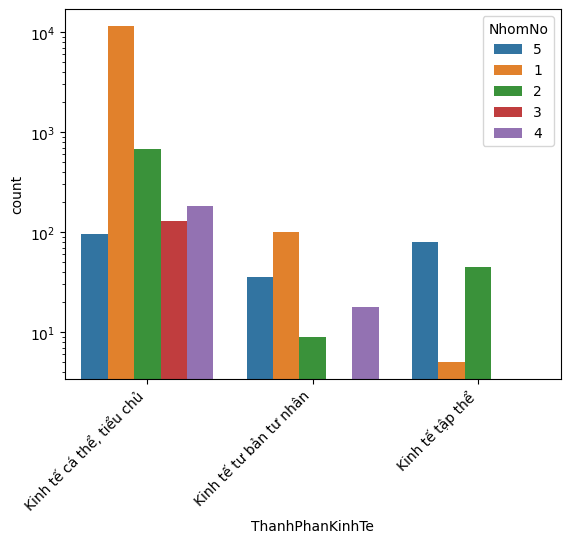

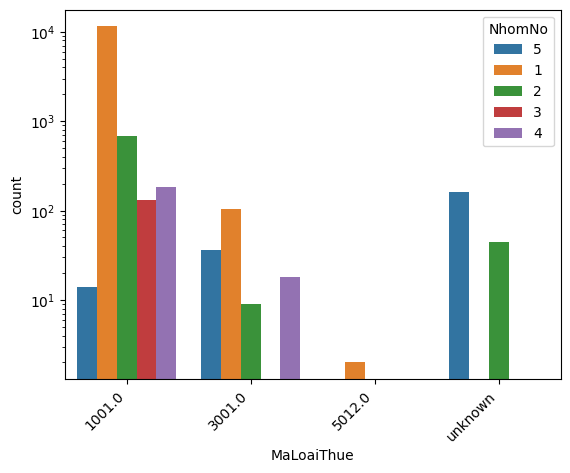

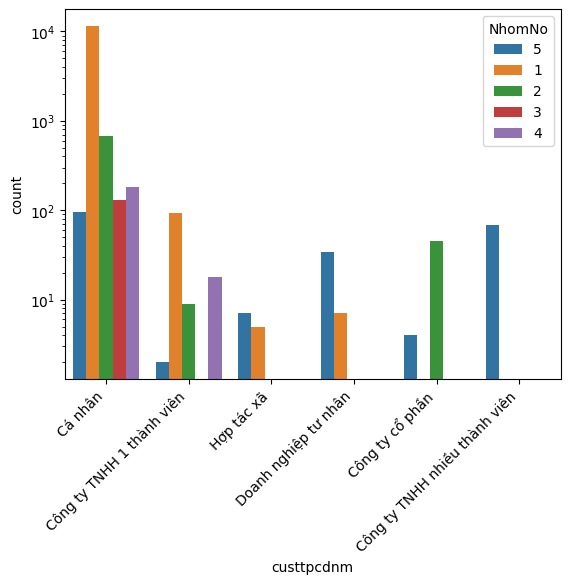

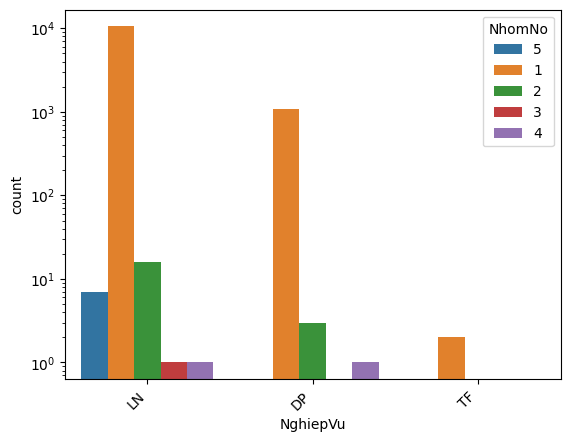

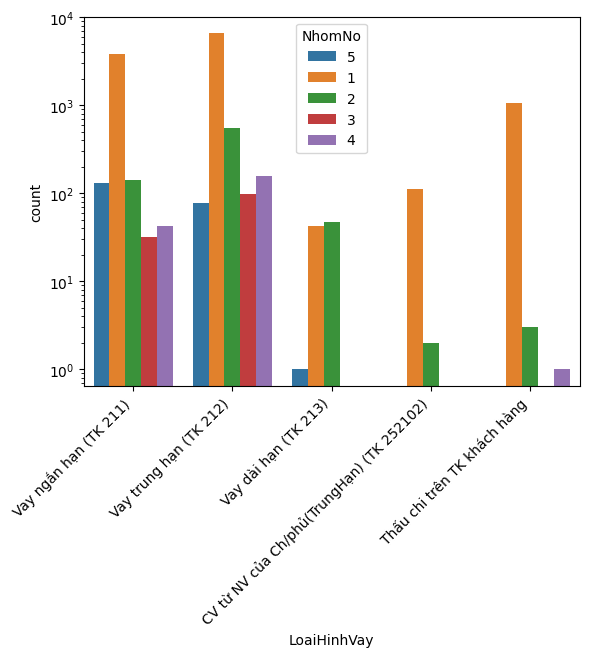

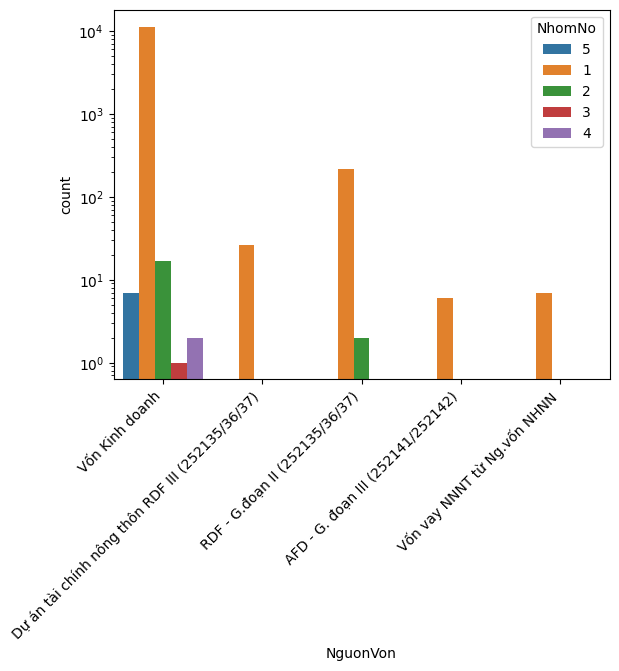

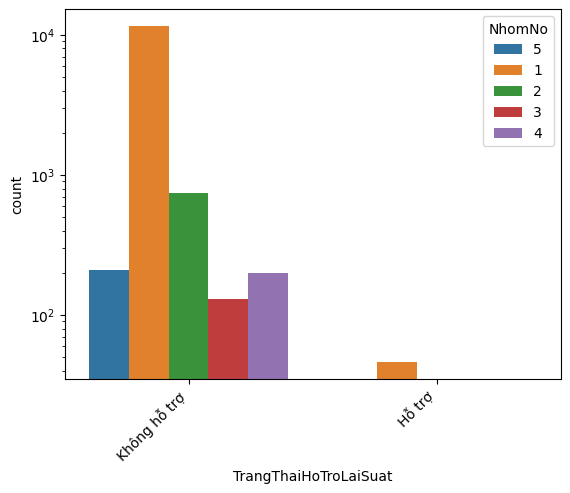

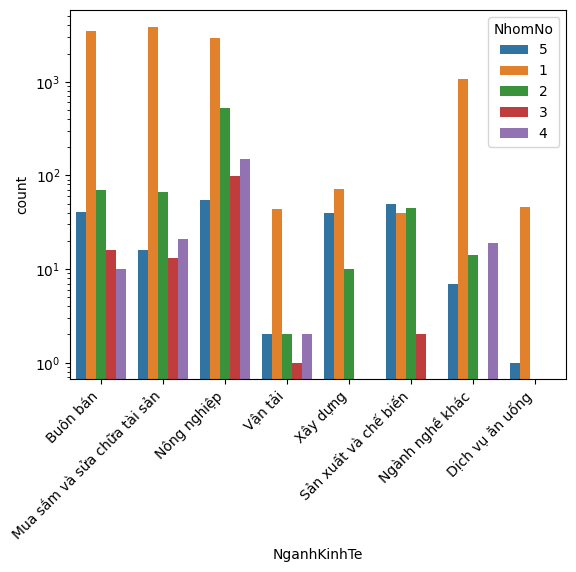

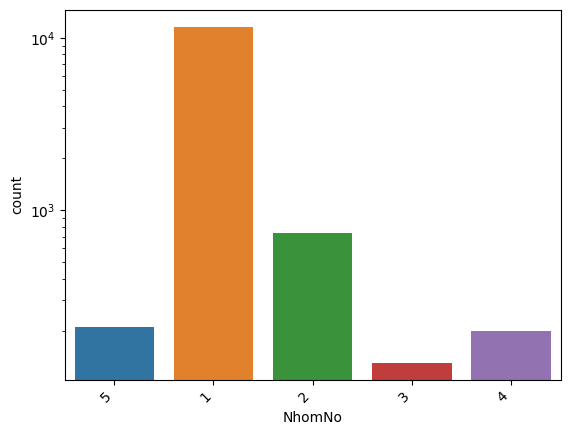

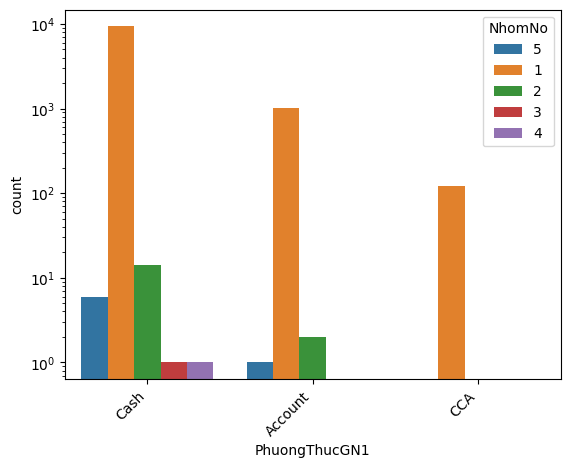

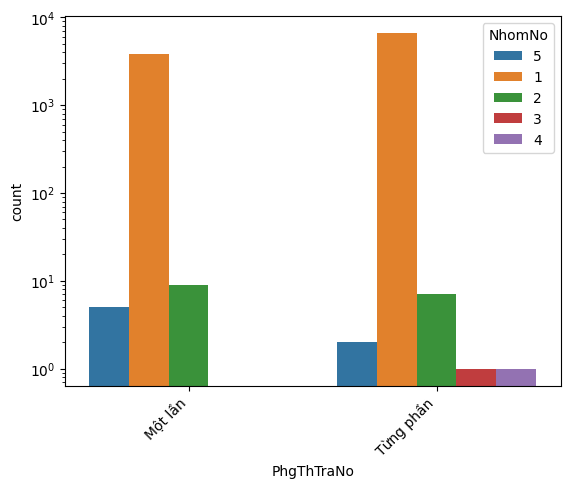

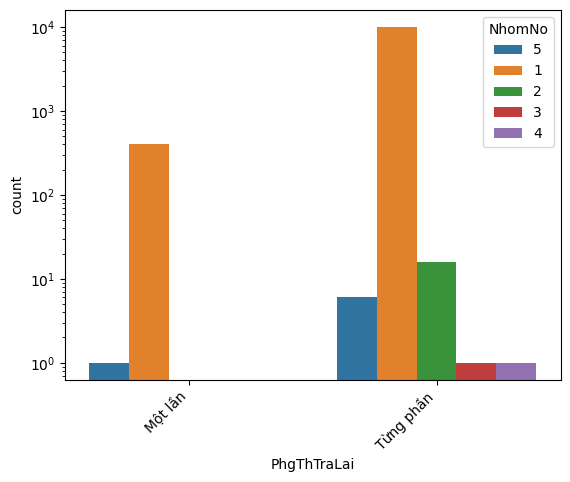

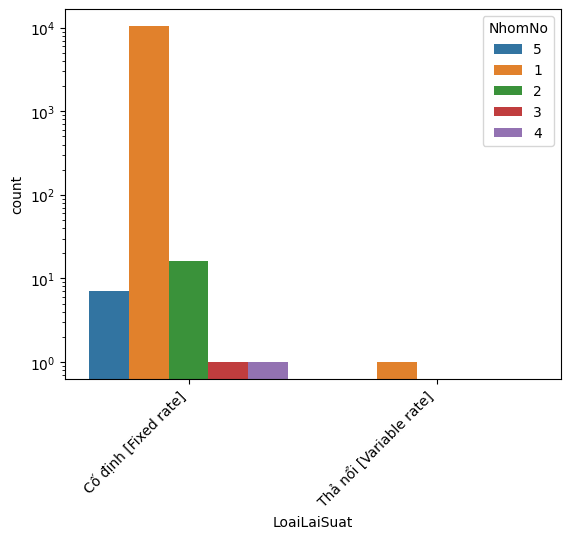

In [40]:
def count_hue(x,hue):
  sb.countplot(data = object_df[object_df[x].notnull()], x = x, hue = hue)
  plt.xticks(rotation = 45, ha = 'right')
  plt.yscale('log')
  plt.show()

for i in object_df.columns:
  count_hue(i,'NhomNo')

- Thêm các cột kiểu object không có giá trị NaN vào mô hình

In [41]:
model_cols.extend(countnull(object_df)[countnull(object_df)['count'] == 0].index)

- Tạo một data frame mới chỉ gồm các cột kiểu datetime từ data frame ban đầu

In [42]:
time_df = create_datetime(df)
time_df

,NgayPheDuyet,NgayDenHanHopDong,NgayGiaiNgan,NgayDenHan,NgayTraLaiCuoiCung,NgayTraGocSapToi,NgayTraLaiSapToi
0,2010-07-16,2011-07-14,2010-07-16,2011-07-14,2010-12-31,2011-07-14,2011-07-14
1,2011-01-21,2011-07-21,2011-01-21,2011-07-21,2011-04-21,2011-07-21,2011-07-21
2,2014-05-14,2019-05-14,2014-05-14,2019-05-14,2018-11-19,2019-02-14,2019-02-14
3,2014-07-16,2019-07-15,2014-07-16,2019-07-15,2018-07-15,2019-01-15,2019-01-16
4,2014-07-18,2019-07-18,2014-07-18,2019-07-18,2018-10-18,2019-01-18,2019-01-18
...,...,...,...,...,...,...,...
8018,2022-06-15,NaT,2022-06-17,2027-06-17,NaT,NaT,NaT
8019,2019-09-10,NaT,2019-09-12,2024-09-12,NaT,NaT,NaT
8020,2021-09-30,NaT,2021-10-02,2024-10-02,NaT,NaT,NaT
8021,2021-12-31,NaT,2022-01-02,2026-01-02,NaT,NaT,NaT


- Đếm số giá trị NaN trong time_df

In [43]:
countnull(time_df)

,count
NgayPheDuyet,0
NgayDenHanHopDong,1249
NgayGiaiNgan,0
NgayDenHan,0
NgayTraLaiCuoiCung,4619
NgayTraGocSapToi,1249
NgayTraLaiSapToi,1249


- Ta có thể thấy bộ dữ liệu có 7 cột kiểu datetime nhưng chỉ có 3 cột không tồn tại NaN. Nhóm sẽ chỉ xử lý 2 cột NgayGiaiNgan và NgayDenHan vì NgayPheDuyet chỉ là ngày hoàn tất các thủ tục để duyệt chi số tiền giải ngân

In [44]:
time_df['DH-GN'] = time_df['NgayDenHan'] - time_df['NgayGiaiNgan']
time_df['DH-GN']

,DH-GN
0,363 days
1,181 days
2,1826 days
3,1825 days
4,1826 days
...,...
8018,1826 days
8019,1827 days
8020,1096 days
8021,1461 days


- Lấy cột NgayDenHan trừ đi cột NgayGiaiNgan ta có được số ngày từ khi giải ngân đến khi đến hạn của khoản vay. Để gọn hơn, lấy số ngày này chia cho 365 để quy đổi thành số năm. Tiếp theo tiến hành vẽ biểu đồ histogram cho kết quả trên. Ta có thể thấy khoảng cách từ khi giải ngân đến khi đến hạn dao động từ 0 đến 16 năm, trong đó phần lớn phân bố ở mức dưới 8 năm

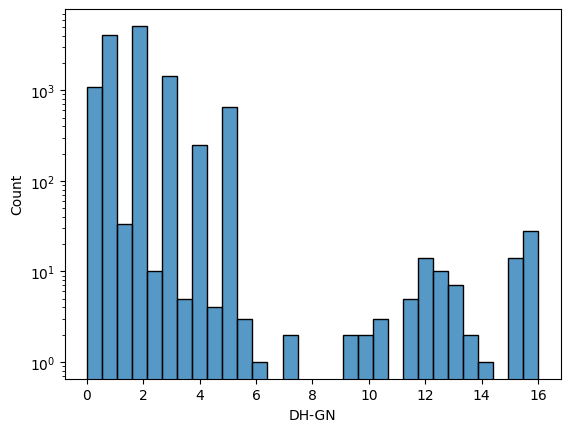

In [45]:
time_df['DH-GN'] = time_df['DH-GN'].dt.days
time_df['DH-GN'] = abs(time_df['DH-GN']) / 365
sb.histplot(time_df['DH-GN'], bins = 30)
plt.yscale('log')

- Thêm đặc trưng DH-GN (số năm giữa ngày giải ngân và ngày đến hạn) vào mô hình huấn luyện và xây dựng data frame để đưa vào mô hình (model_df)

In [46]:
model_cols.extend(['DH-GN'])
model_df = pd.DataFrame()
for i in model_cols:
  try:
    model_df[i] = numeric_df[i]
  except:
    try:
      model_df[i] = object_df[i]
    except:
      model_df[i] = time_df[i]
model_df

,LaiSuat,TyLeBaoBam,NhuCauVon,PhanKyTraLai,ThanhPhanKinhTe,MaLoaiThue,custtpcdnm,LoaiHinhVay,TrangThaiHoTroLaiSuat,NganhKinhTe,NhomNo,DH-GN
0,13.0,0,550000000,0,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay ngắn hạn (TK 211),Không hỗ trợ,Buôn bán,5,0.994521
1,13.0,100,3549000000,3,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay ngắn hạn (TK 211),Không hỗ trợ,Buôn bán,5,0.495890
2,11.7,0,80000000,3,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay trung hạn (TK 212),Không hỗ trợ,Mua sắm và sửa chữa tài sản,1,5.002740
3,11.7,100,507000000,6,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay trung hạn (TK 212),Không hỗ trợ,Mua sắm và sửa chữa tài sản,1,5.000000
4,11.5,0,80000000,6,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay trung hạn (TK 212),Không hỗ trợ,Mua sắm và sửa chữa tài sản,1,5.002740
...,...,...,...,...,...,...,...,...,...,...,...,...
8018,9.2,0,100000000,0,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay trung hạn (TK 212),Không hỗ trợ,Nông nghiệp,4,5.002740
8019,11.0,0,70000000,0,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay trung hạn (TK 212),Không hỗ trợ,Mua sắm và sửa chữa tài sản,4,5.005479
8020,11.0,0,80000000,0,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay trung hạn (TK 212),Không hỗ trợ,Nông nghiệp,4,3.002740
8021,11.0,100,400000000,0,"Kinh tế cá thể, tiểu chủ",1001.0,Cá nhân,Vay trung hạn (TK 212),Không hỗ trợ,Nông nghiệp,4,4.002740


- Áp dụng hàm info lên model_df

In [47]:
info(model_df)

<class 'pandas.core.frame.DataFrame'>
Index: 12849 entries, 0 to 8022
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LaiSuat                12849 non-null  float64
 1   TyLeBaoBam             12849 non-null  int64  
 2   NhuCauVon              12849 non-null  int64  
 3   PhanKyTraLai           12849 non-null  int64  
 4   ThanhPhanKinhTe        12849 non-null  object 
 5   MaLoaiThue             12849 non-null  object 
 6   custtpcdnm             12849 non-null  object 
 7   LoaiHinhVay            12849 non-null  object 
 8   TrangThaiHoTroLaiSuat  12849 non-null  object 
 9   NganhKinhTe            12849 non-null  object 
 10  NhomNo                 12849 non-null  object 
 11  DH-GN                  12849 non-null  float64
dtypes: float64(2), int64(3), object(7)
memory usage: 1.3+ MB


- model_df có tất cả 12 cột, 5 cột kiểu số và 7 cột kiểu object (có cả cột mục tiêu NhomNo)

- Tất cả các cột đều đầy đủ 12849 bản ghi

- Tiếp theo, ta gộp nhóm nợ từ nhóm 1 đến nhóm 3 là các nhóm nợ bình thường, còn nhóm 4 và nhóm 5 là nhóm nợ xấu

In [48]:
model_df['NhomNo'] = list(map(lambda x: 'Nợ xấu' if (x == '4' or x == '5') else 'Nợ bình thường' ,model_df['NhomNo']))

In [49]:
model_df['NhomNo'].value_counts()

,count
NhomNo,
Nợ bình thường,12439
Nợ xấu,410


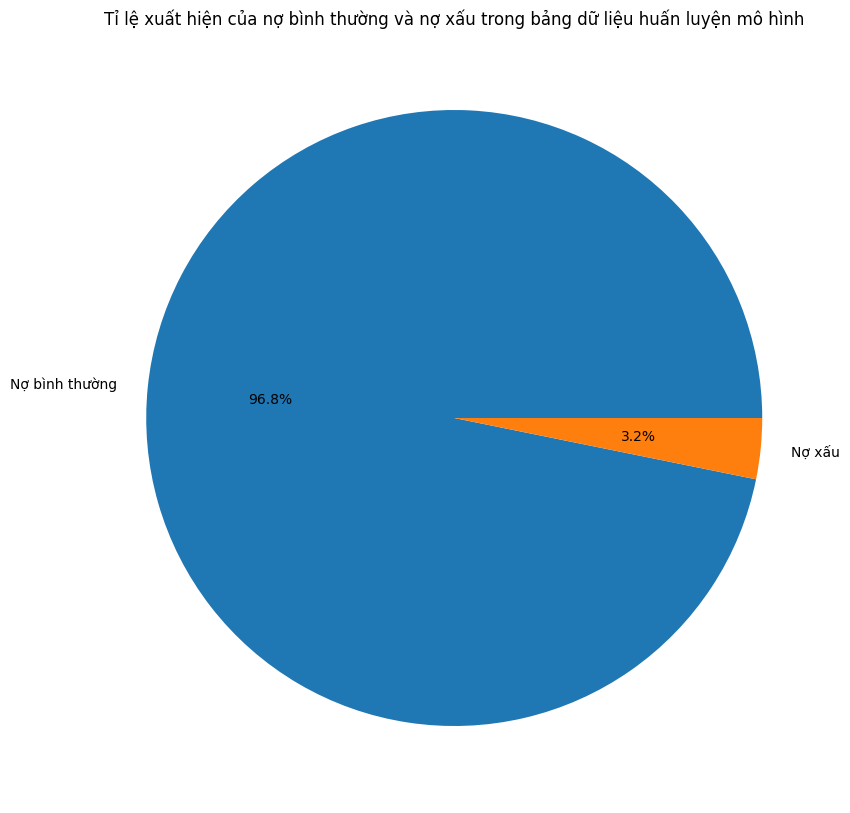

In [50]:
plt.figure(figsize = (10,10))
plt.title("Tỉ lệ xuất hiện của nợ bình thường và nợ xấu trong bảng dữ liệu huấn luyện mô hình")
plt.pie(model_df['NhomNo'].value_counts(), labels = model_df['NhomNo'].value_counts().index, autopct = '%1.1f%%')
plt.show()

- Vẽ biểu đồ cặp (pairplot) cho từng đặc trưng dạng số trong model_df

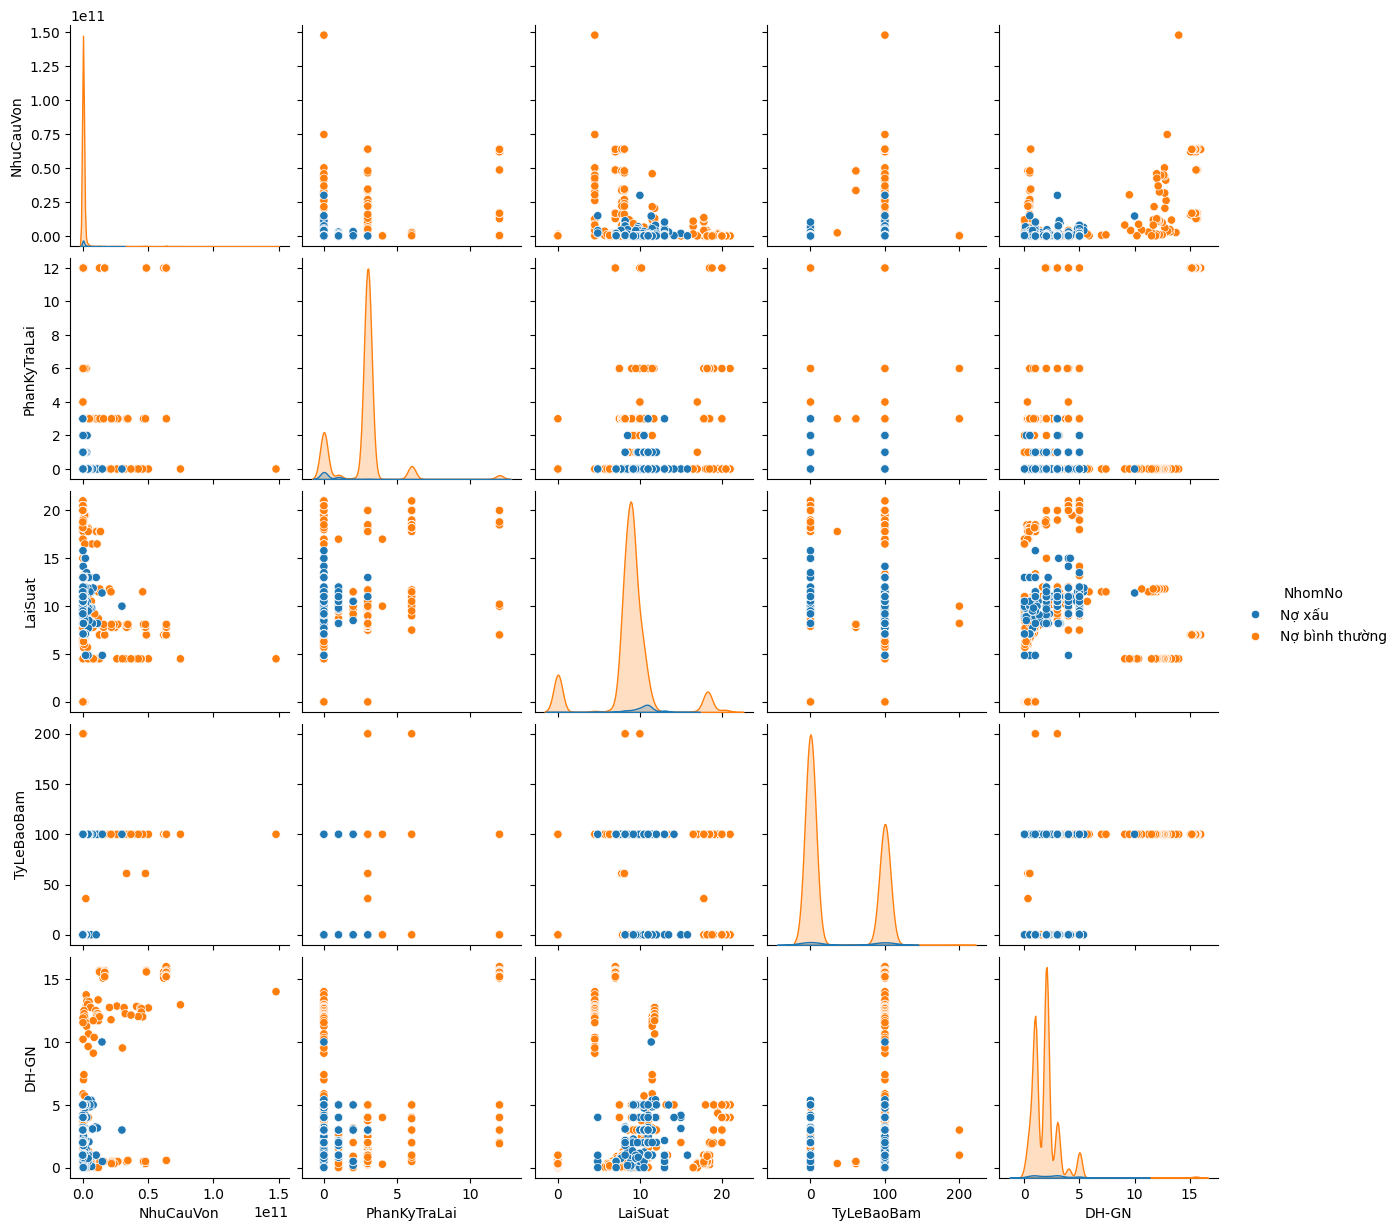

In [51]:
sb.pairplot(data = model_df[['NhuCauVon','PhanKyTraLai','LaiSuat','TyLeBaoBam','DH-GN','NhomNo']], hue = 'NhomNo')

- Tìm hiểu các thông số min, max, trung bình và độ lệch chuẩn của từng nhóm nợ bằng phương thức groupby

In [52]:
model_df[['NhomNo','NhuCauVon','PhanKyTraLai','LaiSuat','TyLeBaoBam','DH-GN']].groupby('NhomNo').agg(['min','max','mean','std'])

NhuCauVon                                            \
                     min           max          mean           std   
NhomNo                                                               
Nợ bình thường         0  147927473670  8.259874e+08  4.536673e+09   
Nợ xấu                 0   30000000000  1.055279e+09  2.338824e+09   

               PhanKyTraLai                         LaiSuat                   \
                        min max      mean       std     min   max       mean   
NhomNo                                                                         
Nợ bình thường            0  12  2.726907  1.740555     0.0  21.0   8.781335   
Nợ xấu                    0  12  0.353659  0.847432     0.0  15.8  10.391268   

                         TyLeBaoBam                                DH-GN  \
                     std        min  max       mean        std       min   
NhomNo                                                                     
Nợ bình thường  3.560017          0  200  36.592411  48.185166  0.005479   
Nợ xấu          1.673344          0  100  47.804878  50.012820  0.016438   

                                               
                      max      mean       std  
NhomNo                                         
Nợ bình thường  16.000000  1.903314  1.476851  
Nợ xấu          10.008219  2.407464  1.534449

- Trực quan hóa bằng biểu đồ cột theo từng nhóm nợ của mỗi đặc trưng dạng object trong model_df

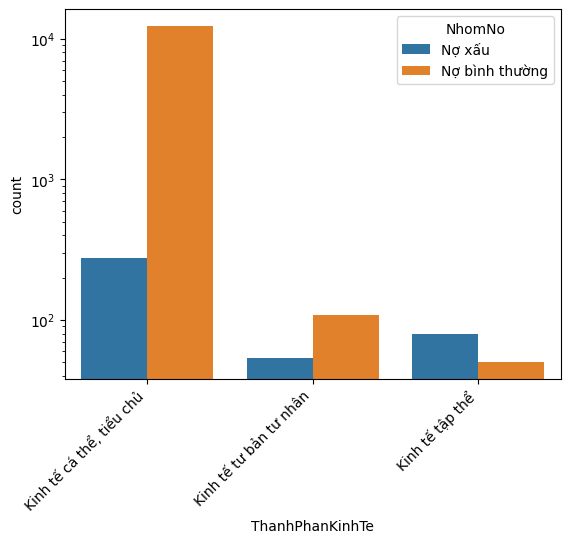

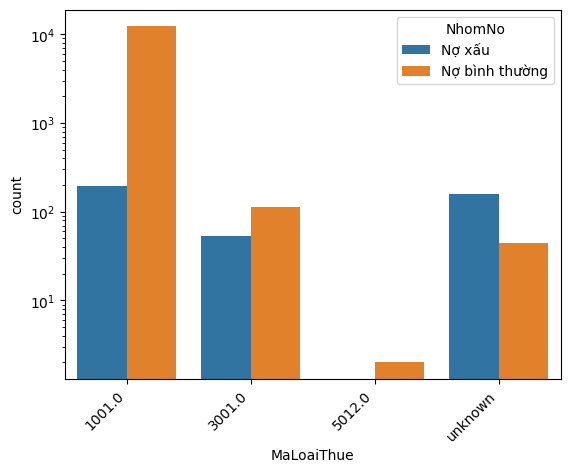

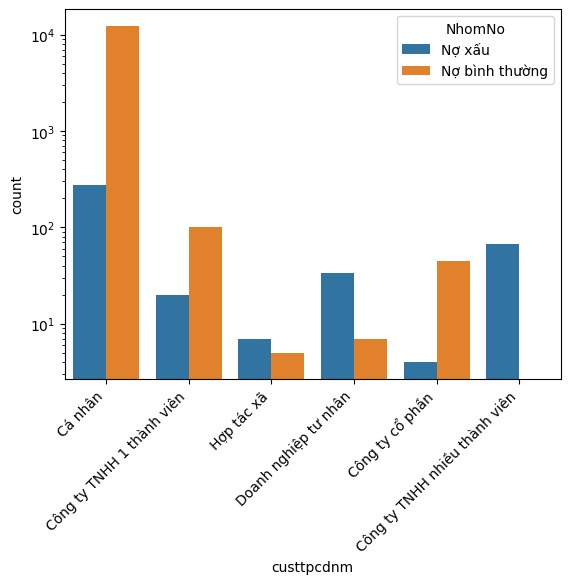

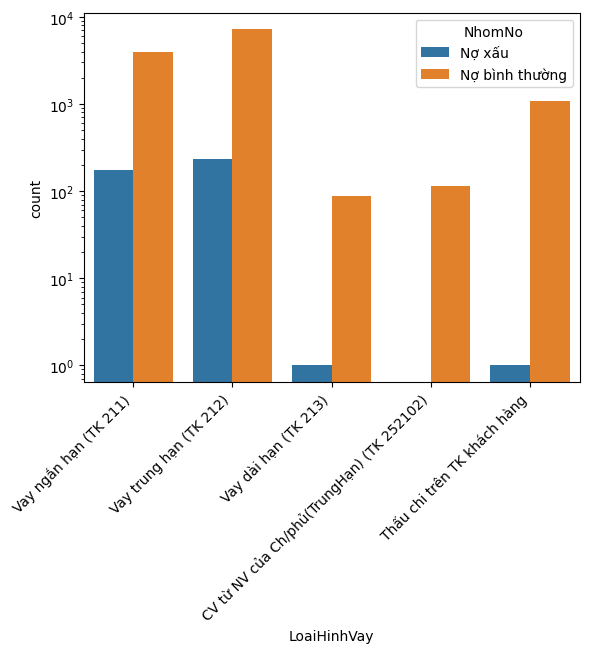

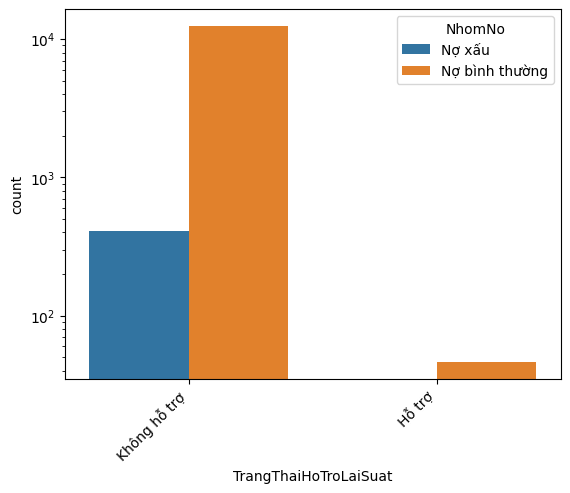

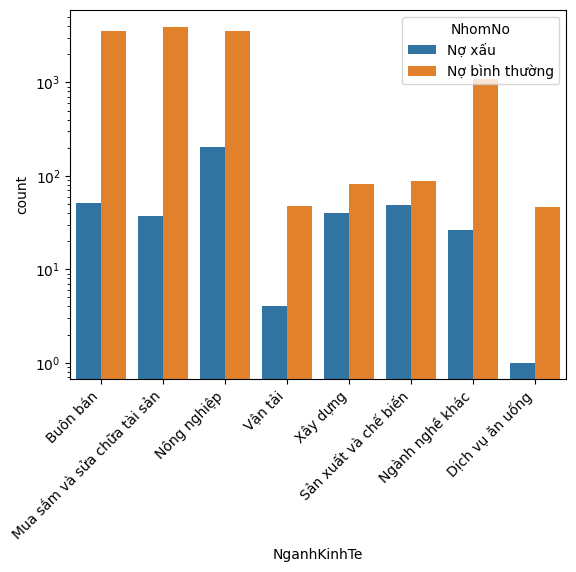

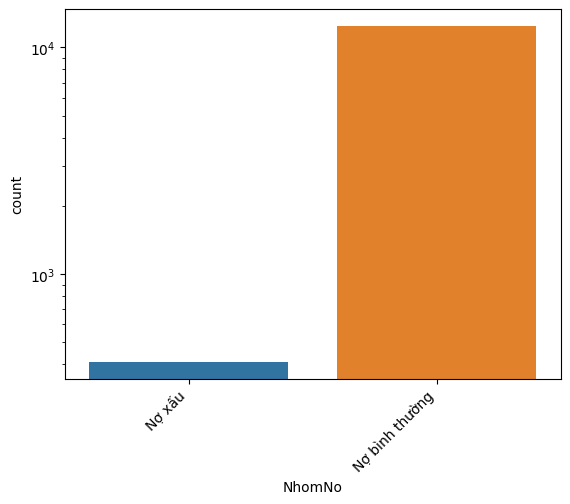

In [53]:
for i in model_df.select_dtypes(include = ['object']).columns:
    sb.countplot(x = i, data = model_df, hue = 'NhomNo')
    plt.yscale('log')
    plt.xticks(rotation = 45, ha = 'right')
    plt.show()

In [54]:
model_df.to_csv('model_df.csv', index = False)